In [1]:
# pip install duckdb matplotlib seaborn

In [2]:
import duckdb
import psutil
import time
import pandas as pd
from pathlib import Path
from statistics import mean, median
from typing import Callable
import tracemalloc
import shutil

def init_duckdb_connection() -> duckdb.DuckDBPyConnection:
    """Инициализация DuckDB соединения"""
    con = duckdb.connect()
    return con

def measure_operation(
    func: Callable,
    warmup: bool = True,
    iterations: int = 3
) -> dict:
    """
    Измерение производительности операции с улучшенной точностью
    
    Args:
        func: Функция для измерения
        warmup: Выполнить прогрев перед измерениями
        iterations: Количество итераций для усреднения
    
    Returns:
        dict с метриками: time, cpu_percent, memory_mb
    """
    process = psutil.Process()
    
    # Прогрев для минимизации cold start эффектов
    if warmup:
        try:
            func()
        except Exception:
            pass  # Прогрев может использовать кэш
    
    times = []
    cpu_usages = []
    memory_usages = []
    
    for _ in range(iterations):
        # Начальное состояние
        cpu_start = process.cpu_percent(interval=0.1)
        tracemalloc.start()
        
        # Измерение
        time_start = time.perf_counter()
        func()
        time_end = time.perf_counter()
        
        # Сбор метрик
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        cpu_end = process.cpu_percent(interval=0.1)
        
        times.append(time_end - time_start)
        cpu_usages.append(max(cpu_start, cpu_end))  # Берём максимальное значение
        memory_usages.append(peak / 1024 / 1024)  # MB
        
        # Пауза между итерациями
        time.sleep(0.5)
    
    return {
        'time_mean': round(mean(times), 3),
        'time_median': round(median(times), 3),
        'time_min': round(min(times), 3),
        'time_max': round(max(times), 3),
        'cpu_percent_mean': round(mean(cpu_usages), 2),
        'cpu_percent_max': round(max(cpu_usages), 2),
        'memory_mb_peak': round(max(memory_usages), 2)
    }

def get_file_size_mb(file_path: Path) -> float:
    """Получение размера файла в MB"""
    if file_path.exists():
        return round(file_path.stat().st_size / 1024 / 1024, 2)
    return 0.0

def get_directory_size_mb(directory: Path) -> tuple[float, int]:
    """
    Получение общего размера директории и количества файлов
    
    Returns:
        tuple: (размер в MB, количество файлов)
    """
    total_size = 0
    file_count = 0
    
    if directory.exists():
        for file_path in directory.rglob('*.parquet'):
            total_size += file_path.stat().st_size
            file_count += 1
    
    return round(total_size / 1024 / 1024, 2), file_count

def benchmark_compression_methods(
    source_file: str = 'data.parquet',
    output_dir: str = 'benchmark_results',
    iterations: int = 3,
    cleanup: bool = True
) -> pd.DataFrame:
    """
    Комплексное тестирование методов сжатия
    
    Args:
        source_file: Путь к исходному файлу parquet
        output_dir: Директория для сохранения результатов
        iterations: Количество итераций для каждого теста чтения
        cleanup: Удалять ли директории после теста (для экономии места)
    
    Returns:
        DataFrame с результатами бенчмарка
    """
    
    # Инициализация
    con = init_duckdb_connection()
    source_path = Path(source_file)
    output_path = Path(output_dir)
    
    # Проверка существования исходного файла
    if not source_path.exists():
        raise FileNotFoundError(f"Файл {source_file} не найден!")
    
    # Создание директории для результатов
    output_path.mkdir(exist_ok=True)
    
    # Получение размера исходного файла
    original_size_mb = get_file_size_mb(source_path)
    
    # Получение количества записей
    row_count = con.sql(
        f"SELECT COUNT(*) as cnt FROM read_parquet('{source_path}')"
    ).fetchone()[0]
    
    print(f"\n{'='*80}")
    print(f"📊 Бенчмарк сжатия Parquet")
    print(f"📁 Исходный файл: {source_file}")
    print(f"📏 Размер: {original_size_mb} MB")
    print(f"📈 Записей: {row_count:,}")
    print(f"🔄 Итераций на тест чтения: {iterations}")
    print(f"💾 Результаты сохраняются в: {output_dir}/")
    print(f"{'='*80}\n")
    
    # Конфигурация алгоритмов сжатия
    compressions = [
        # Baseline
        ("uncompressed", "COMPRESSION UNCOMPRESSED", "uncompressed"),
        
        # Быстрые алгоритмы (Hot storage)
        ("snappy", "COMPRESSION SNAPPY", "snappy"),
        ("lz4", "COMPRESSION LZ4", "lz4"),
        
        # Сбалансированные (Warm storage)
        ("gzip", "COMPRESSION GZIP", "gzip"),
        ("zstd-1", "COMPRESSION ZSTD, COMPRESSION_LEVEL 1", "zstd_lvl1"),
        ("zstd-2", "COMPRESSION ZSTD, COMPRESSION_LEVEL 2", "zstd_lvl2"),
        ("zstd-3", "COMPRESSION ZSTD, COMPRESSION_LEVEL 3", "zstd_lvl3"),
        ("zstd-4", "COMPRESSION ZSTD, COMPRESSION_LEVEL 4", "zstd_lvl4"),
        ("zstd-5", "COMPRESSION ZSTD, COMPRESSION_LEVEL 5", "zstd_lvl5"),
        ("zstd-6", "COMPRESSION ZSTD, COMPRESSION_LEVEL 6", "zstd_lvl6"),
        ("zstd-7", "COMPRESSION ZSTD, COMPRESSION_LEVEL 7", "zstd_lvl7"),
        
        # Высокое сжатие (Cold storage)
        ("zstd-8", "COMPRESSION ZSTD, COMPRESSION_LEVEL 8", "zstd_lvl8"),
        ("zstd-9", "COMPRESSION ZSTD, COMPRESSION_LEVEL 9", "zstd_lvl9"),
        ("zstd-10", "COMPRESSION ZSTD, COMPRESSION_LEVEL 10", "zstd_lvl10"),
        ("zstd-11", "COMPRESSION ZSTD, COMPRESSION_LEVEL 11", "zstd_lvl11"),
        ("zstd-12", "COMPRESSION ZSTD, COMPRESSION_LEVEL 12", "zstd_lvl12"),
        ("zstd-13", "COMPRESSION ZSTD, COMPRESSION_LEVEL 13", "zstd_lvl13"),
        ("zstd-14", "COMPRESSION ZSTD, COMPRESSION_LEVEL 14", "zstd_lvl14"),
        ("zstd-15", "COMPRESSION ZSTD, COMPRESSION_LEVEL 15", "zstd_lvl15"),
        
        # Экстремальное сжатие (для сравнения)
        ("zstd-16", "COMPRESSION ZSTD, COMPRESSION_LEVEL 16", "zstd_lvl16"),
        ("zstd-17", "COMPRESSION ZSTD, COMPRESSION_LEVEL 17", "zstd_lvl17"),
        ("zstd-18", "COMPRESSION ZSTD, COMPRESSION_LEVEL 18", "zstd_lvl18"),
        ("zstd-19", "COMPRESSION ZSTD, COMPRESSION_LEVEL 19", "zstd_lvl19"),
        ("zstd-20", "COMPRESSION ZSTD, COMPRESSION_LEVEL 20", "zstd_lvl20"),
        ("zstd-21", "COMPRESSION ZSTD, COMPRESSION_LEVEL 21", "zstd_lvl21"),
        ("zstd-22", "COMPRESSION ZSTD, COMPRESSION_LEVEL 22", "zstd_lvl22"),
    ]
    
    results = []
    
    for name, compression_clause, dir_suffix in compressions:
        test_dir = output_path / dir_suffix
        test_file = test_dir / "data.parquet"
        
        # Создание директории для теста
        test_dir.mkdir(exist_ok=True)
        
        print(f"🔧 [{name.upper()}] Начало теста...")
        
        # === ЗАПИСЬ ===
        sql_write = f"""
            COPY (
                SELECT *
                FROM read_parquet('{source_path}')
            )
            TO '{test_file}' (
                FORMAT PARQUET,
                {compression_clause}
            );
        """
        
        def write_func():
            con.sql(sql_write)
        
        print(f"   ✍️  Запись...")
        write_metrics = measure_operation(write_func, warmup=False, iterations=1)
        
        # Размер сжатого файла
        compressed_size_mb, file_count = get_directory_size_mb(test_dir)
        
        # === ЧТЕНИЕ ===
        def read_func():
            con.sql(f"SELECT COUNT(*) FROM read_parquet('{test_file}');").fetchone()
        
        print(f"   📖 Чтение...")
        read_metrics = measure_operation(read_func, warmup=True, iterations=iterations)
        
        # === РАСЧЁТ МЕТРИК ===
        compression_ratio = round(original_size_mb / compressed_size_mb, 2) if compressed_size_mb > 0 else 0
        space_savings_percent = round((1 - compressed_size_mb / original_size_mb) * 100, 1) if original_size_mb > 0 else 0
        
        write_throughput = round(original_size_mb / write_metrics['time_mean'], 2) if write_metrics['time_mean'] > 0 else 0
        read_throughput = round(compressed_size_mb / read_metrics['time_median'], 2) if read_metrics['time_median'] > 0 else 0
        
        # Комплексная оценка (нормализованная)
        # Формула: (compression_ratio * read_throughput) / (write_time + read_time)
        total_time = write_metrics['time_mean'] + read_metrics['time_median']
        efficiency_score = round(
            (compression_ratio * read_throughput) / total_time,
            2
        ) if total_time > 0 else 0
        
        result = {
            "Compression": name,
            "Write Time (s)": write_metrics['time_mean'],
            "Write CPU (%)": write_metrics['cpu_percent_mean'],
            "Write CPU Max (%)": write_metrics['cpu_percent_max'],
            "Write Memory (MB)": write_metrics['memory_mb_peak'],
            "Read Time (s)": read_metrics['time_median'],
            "Read Time Std (s)": round(read_metrics['time_max'] - read_metrics['time_min'], 3),
            "Read CPU (%)": read_metrics['cpu_percent_mean'],
            "Read CPU Max (%)": read_metrics['cpu_percent_max'],
            "Read Memory (MB)": read_metrics['memory_mb_peak'],
            "File Size (MB)": compressed_size_mb,
            "Original Size (MB)": original_size_mb,
            "Compression Ratio": compression_ratio,
            "Space Savings (%)": space_savings_percent,
            "Write Throughput (MB/s)": write_throughput,
            "Read Throughput (MB/s)": read_throughput,
            "Efficiency Score": efficiency_score,
            "Row Count": row_count,
            "File Count": file_count,
            "Local Path": str(test_file)
        }
        
        results.append(result)
        
        print(f"   ✅ Готово: {compressed_size_mb} MB (ratio: {compression_ratio}x, -{space_savings_percent}%)\n")
        
        # Очистка для экономии места (опционально)
        if cleanup and name not in ['uncompressed', 'zstd-7']:  # Сохраняем baseline и рекомендованный
            shutil.rmtree(test_dir, ignore_errors=True)
    
    con.close()
    
    df = pd.DataFrame(results)
    
    # Добавление рангов для удобства анализа
    df['Rank_Compression'] = df['Compression Ratio'].rank(ascending=False)
    df['Rank_ReadSpeed'] = df['Read Throughput (MB/s)'].rank(ascending=False)
    df['Rank_WriteSpeed'] = df['Write Throughput (MB/s)'].rank(ascending=False)
    df['Rank_Overall'] = df['Efficiency Score'].rank(ascending=False)
    
    return df

# Функция для быстрого анализа результатов
def analyze_results(df: pd.DataFrame) -> None:
    """
    Вывод краткого анализа результатов
    
    Args:
        df: DataFrame с результатами бенчмарка
    """
    print("\n" + "="*80)
    print("📈 АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*80)
    
    # Лучшее сжатие
    best_compression = df.loc[df['Compression Ratio'].idxmax()]
    print(f"\n🏆 Лучшее сжатие: {best_compression['Compression']}")
    print(f"   Compression Ratio: {best_compression['Compression Ratio']}x")
    print(f"   Размер: {best_compression['File Size (MB)']} MB")
    print(f"   Экономия: {best_compression['Space Savings (%)']}%")
    
    # Самая быстрая запись
    fastest_write = df.loc[df['Write Throughput (MB/s)'].idxmax()]
    print(f"\n⚡ Самая быстрая запись: {fastest_write['Compression']}")
    print(f"   Throughput: {fastest_write['Write Throughput (MB/s)']} MB/s")
    print(f"   Время: {fastest_write['Write Time (s)']} s")
    
    # Самое быстрое чтение
    fastest_read = df.loc[df['Read Throughput (MB/s)'].idxmax()]
    print(f"\n🚀 Самое быстрое чтение: {fastest_read['Compression']}")
    print(f"   Throughput: {fastest_read['Read Throughput (MB/s)']} MB/s")
    print(f"   Время: {fastest_read['Read Time (s)']} s")
    
    # Лучший баланс
    best_balance = df.loc[df['Efficiency Score'].idxmax()]
    print(f"\n⚖️  Лучший баланс (Efficiency Score): {best_balance['Compression']}")
    print(f"   Score: {best_balance['Efficiency Score']}")
    print(f"   Compression Ratio: {best_balance['Compression Ratio']}x")
    print(f"   Read Throughput: {best_balance['Read Throughput (MB/s)']} MB/s")
    
    # Рекомендации
    print(f"\n💡 Рекомендации:")
    print(f"   • Hot Storage (скорость важнее): {df.nlargest(1, 'Read Throughput (MB/s)')['Compression'].values[0]}")
    print(f"   • Warm Storage (баланс): {best_balance['Compression']}")
    print(f"   • Cold Storage (размер важнее): {best_compression['Compression']}")
    
    print("\n" + "="*80)

# Функция для сохранения результатов
def save_results(df: pd.DataFrame, filename: str = 'benchmark_results.csv') -> None:
    """
    Сохранение результатов в CSV
    
    Args:
        df: DataFrame с результатами
        filename: Имя файла для сохранения
    """
    df.to_csv(filename, index=False)
    print(f"\n💾 Результаты сохранены в: {filename}")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_compression_analysis(results_df):
    """
    Создание детальных графиков анализа сжатия
    
    Args:
        results_df: DataFrame с результатами бенчмарка
    """
    
    # Настройка стиля
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['font.size'] = 10
    
    # ========================================================================
    # График 1: Compression Ratio
    # ========================================================================
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    
    bars = ax1.bar(results_df['Compression'], results_df['Compression Ratio'], 
                   color='steelblue', alpha=0.8, edgecolor='black')
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x',
                ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Compression Ratio', fontsize=12, fontweight='bold')
    ax1.set_title('📦 Коэффициент сжатия по алгоритмам', fontsize=14, fontweight='bold', pad=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='Baseline (1.0x)')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 2: Write Time (отдельно)
    # ========================================================================
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    
    bars_write = ax2.bar(results_df['Compression'], results_df['Write Time (s)'], 
                         color='coral', alpha=0.8, edgecolor='black')
    
    # Добавляем значения
    for bar in bars_write:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s',
                ha='center', va='bottom', fontsize=8)
    
    ax2.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Время записи (секунды)', fontsize=12, fontweight='bold')
    ax2.set_title('✍️  Время записи файла', fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 3: Read Time (отдельно)
    # ========================================================================
    fig3, ax3 = plt.subplots(figsize=(14, 6))
    
    bars_read = ax3.bar(results_df['Compression'], results_df['Read Time (s)'], 
                        color='lightgreen', alpha=0.8, edgecolor='black')
    
    # Добавляем значения
    for bar in bars_read:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s',
                ha='center', va='bottom', fontsize=8)
    
    ax3.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Время чтения (секунды)', fontsize=12, fontweight='bold')
    ax3.set_title('📖 Время чтения файла', fontsize=14, fontweight='bold', pad=20)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 4: Throughput (Write + Read)
    # ========================================================================
    fig4, ax4 = plt.subplots(figsize=(14, 6))
    
    ax4.plot(results_df['Compression'], results_df['Write Throughput (MB/s)'], 
             marker='o', linewidth=2.5, markersize=8, label='Write Throughput', 
             color='orangered', alpha=0.8)
    ax4.plot(results_df['Compression'], results_df['Read Throughput (MB/s)'], 
             marker='s', linewidth=2.5, markersize=8, label='Read Throughput', 
             color='dodgerblue', alpha=0.8)
    
    ax4.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Throughput (MB/s)', fontsize=12, fontweight='bold')
    ax4.set_title('🚀 Пропускная способность (Write vs Read)', fontsize=14, fontweight='bold', pad=20)
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend(fontsize=11, loc='best')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 5: Efficiency Score (отсортирован по убыванию)
    # ========================================================================
    fig5, ax5 = plt.subplots(figsize=(14, 8))
    
    # Сортировка по Efficiency Score
    df_sorted = results_df.sort_values('Efficiency Score', ascending=True)  # ascending=True для горизонтального графика
    
    colors = plt.cm.RdYlGn(df_sorted['Efficiency Score'] / df_sorted['Efficiency Score'].max())
    bars_eff = ax5.barh(df_sorted['Compression'], df_sorted['Efficiency Score'], 
                        color=colors, alpha=0.85, edgecolor='black')
    
    # Добавляем значения
    for i, (bar, value) in enumerate(zip(bars_eff, df_sorted['Efficiency Score'])):
        ax5.text(value, bar.get_y() + bar.get_height()/2, 
                f' {value:.2f}', 
                va='center', ha='left', fontsize=9, fontweight='bold')
    
    ax5.set_xlabel('Efficiency Score', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax5.set_title('⚖️  Комплексная оценка эффективности (отсортировано)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax5.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Все графики построены!")


def plot_comparison_summary(results_df):
    """
    Сводный график сравнения ключевых метрик (опционально)
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. File Size
    axes[0, 0].bar(results_df['Compression'], results_df['File Size (MB)'], 
                   color='mediumpurple', alpha=0.7)
    axes[0, 0].axhline(y=results_df['Original Size (MB)'].iloc[0], 
                       color='red', linestyle='--', label='Original Size')
    axes[0, 0].set_title('Размер файла (MB)', fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Space Savings
    savings = results_df['Space Savings (%)']
    colors_savings = ['green' if x > 0 else 'red' for x in savings]
    axes[0, 1].bar(results_df['Compression'], savings, color=colors_savings, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linewidth=1)
    axes[0, 1].set_title('Экономия места (%)', fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Write + Read Time stacked
    axes[1, 0].bar(results_df['Compression'], results_df['Write Time (s)'], 
                   label='Write', alpha=0.8, color='coral')
    axes[1, 0].bar(results_df['Compression'], results_df['Read Time (s)'], 
                   bottom=results_df['Write Time (s)'],
                   label='Read', alpha=0.8, color='lightgreen')
    axes[1, 0].set_title('Суммарное время (Write + Read)', fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Compression Ratio vs Efficiency Score (scatter)
    scatter = axes[1, 1].scatter(results_df['Compression Ratio'], 
                                 results_df['Efficiency Score'],
                                 s=200, c=results_df['Read Throughput (MB/s)'], 
                                 cmap='viridis', alpha=0.7, edgecolors='black')
    
    # Подписываем точки
    for i, txt in enumerate(results_df['Compression']):
        axes[1, 1].annotate(txt, 
                           (results_df['Compression Ratio'].iloc[i], 
                            results_df['Efficiency Score'].iloc[i]),
                           fontsize=8, ha='center')
    
    axes[1, 1].set_xlabel('Compression Ratio', fontweight='bold')
    axes[1, 1].set_ylabel('Efficiency Score', fontweight='bold')
    axes[1, 1].set_title('Compression Ratio vs Efficiency', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Read Throughput (MB/s)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Сводный график построен!")


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data_1_000.parquet
📏 Размер: 0.13 MB
📈 Записей: 1,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.16 MB (ratio: 0.81x, --23.1%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.09 MB (ratio: 1.44x, -30.8%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.1 MB (ratio: 1.3x, -23.1%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.06 MB (ratio: 2.17x, -53.8%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.06 MB (ratio: 2.17x, -53.8%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.07 MB (ratio: 1.86x, -46.2%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.06 MB (ratio: 2.17x, -53.8%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.07 MB (ratio: 1.86x, -4

,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,0.004,1.7,1.7,0.01,0.001,0.001,0.57,1.5,0.0,...,32.50,160.00,25920.00,1000,1,benchmark_results/uncompressed/data.parquet,26.0,1.0,1.0,1.0
1,snappy,0.009,1.1,1.1,0.00,0.002,0.000,0.67,1.7,0.0,...,14.44,45.00,5890.91,1000,1,benchmark_results/snappy/data.parquet,24.0,6.0,8.5,10.0
2,lz4,0.006,1.9,1.9,0.00,0.003,0.001,0.53,1.3,0.0,...,21.67,33.33,4814.33,1000,1,benchmark_results/lz4/data.parquet,25.0,8.0,3.0,11.0
3,gzip,0.021,1.6,1.6,0.00,0.001,0.001,0.43,1.1,0.0,...,6.19,60.00,5918.18,1000,1,benchmark_results/gzip/data.parquet,11.0,4.0,16.0,9.0
4,zstd-1,0.007,0.7,0.7,0.00,0.002,0.000,0.43,1.1,0.0,...,18.57,30.00,7233.33,1000,1,benchmark_results/zstd_lvl1/data.parquet,11.0,17.0,4.0,6.0
5,zstd-2,0.008,1.5,1.5,0.00,0.001,0.001,0.43,1.0,0.0,...,16.25,70.00,14466.67,1000,1,benchmark_results/zstd_lvl2/data.parquet,22.5,2.0,6.0,2.0
6,zstd-3,0.009,1.6,1.6,0.00,0.001,0.000,0.47,1.0,0.0,...,14.44,60.00,13020.00,1000,1,benchmark_results/zstd_lvl3/data.parquet,11.0,4.0,8.5,3.0
7,zstd-4,0.008,1.7,1.7,0.00,0.002,0.000,0.67,1.6,0.0,...,16.25,35.00,6510.00,1000,1,benchmark_results/zstd_lvl4/data.parquet,22.5,7.0,6.0,7.5
8,zstd-5,0.011,1.6,1.6,0.00,0.001,0.001,0.47,1.2,0.0,...,11.82,60.00,10850.00,1000,1,benchmark_results/zstd_lvl5/data.parquet,11.0,4.0,10.0,4.0
9,zstd-6,0.005,1.0,1.0,0.00,0.002,0.001,0.40,1.0,0.0,...,26.00,30.00,9300.00,1000,1,benchmark_results/zstd_lvl6/data.parquet,11.0,17.0,2.0,5.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: gzip
   Compression Ratio: 2.17x
   Размер: 0.06 MB
   Экономия: 53.8%

⚡ Самая быстрая запись: uncompressed
   Throughput: 32.5 MB/s
   Время: 0.004 s

🚀 Самое быстрое чтение: uncompressed
   Throughput: 160.0 MB/s
   Время: 0.001 s

⚖️  Лучший баланс (Efficiency Score): uncompressed
   Score: 25920.0
   Compression Ratio: 0.81x
   Read Throughput: 160.0 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): uncompressed
   • Warm Storage (баланс): uncompressed
   • Cold Storage (размер важнее): gzip



/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


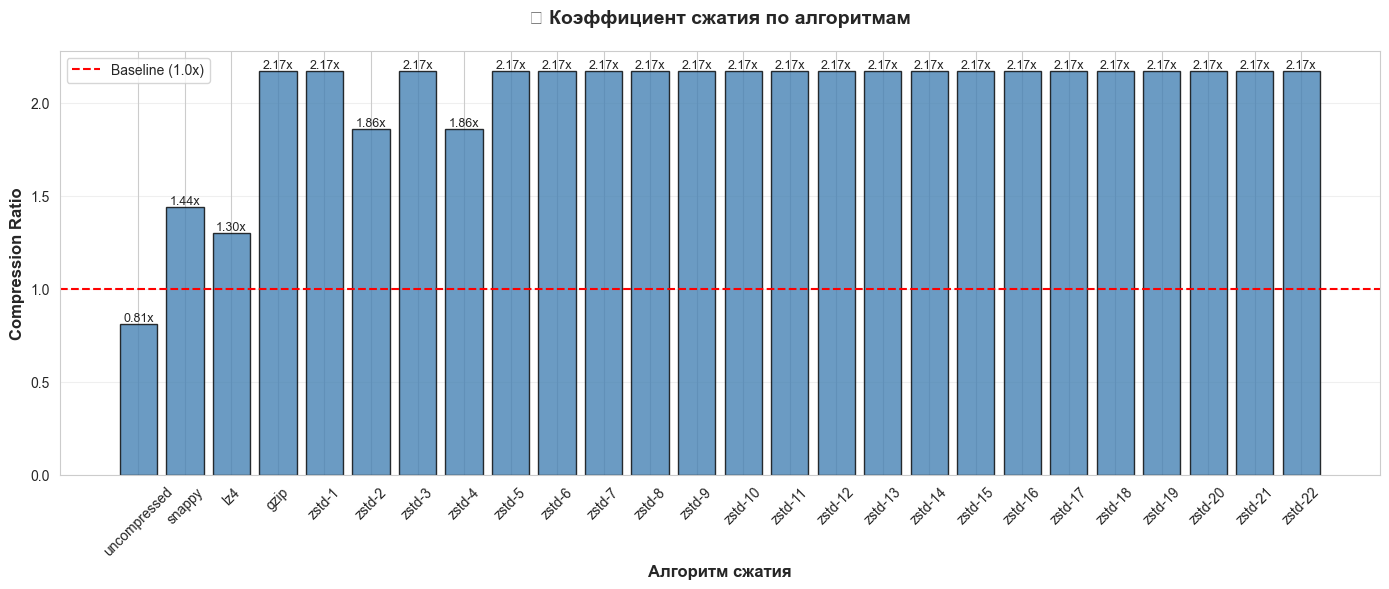

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


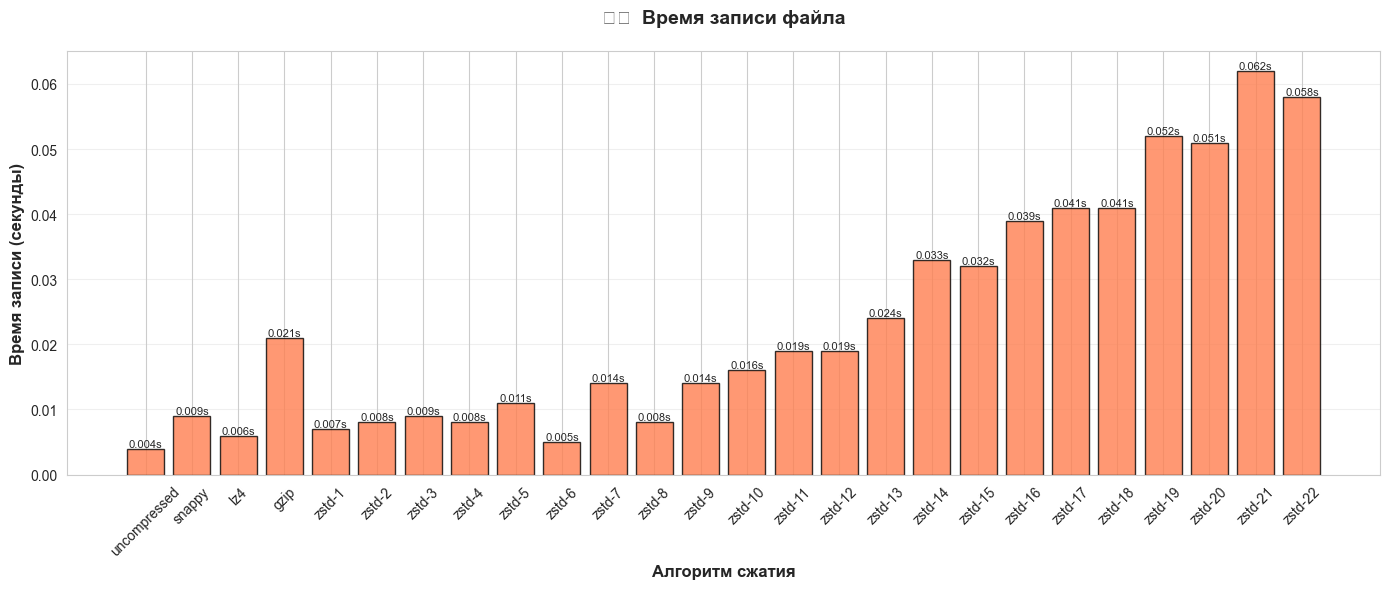

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


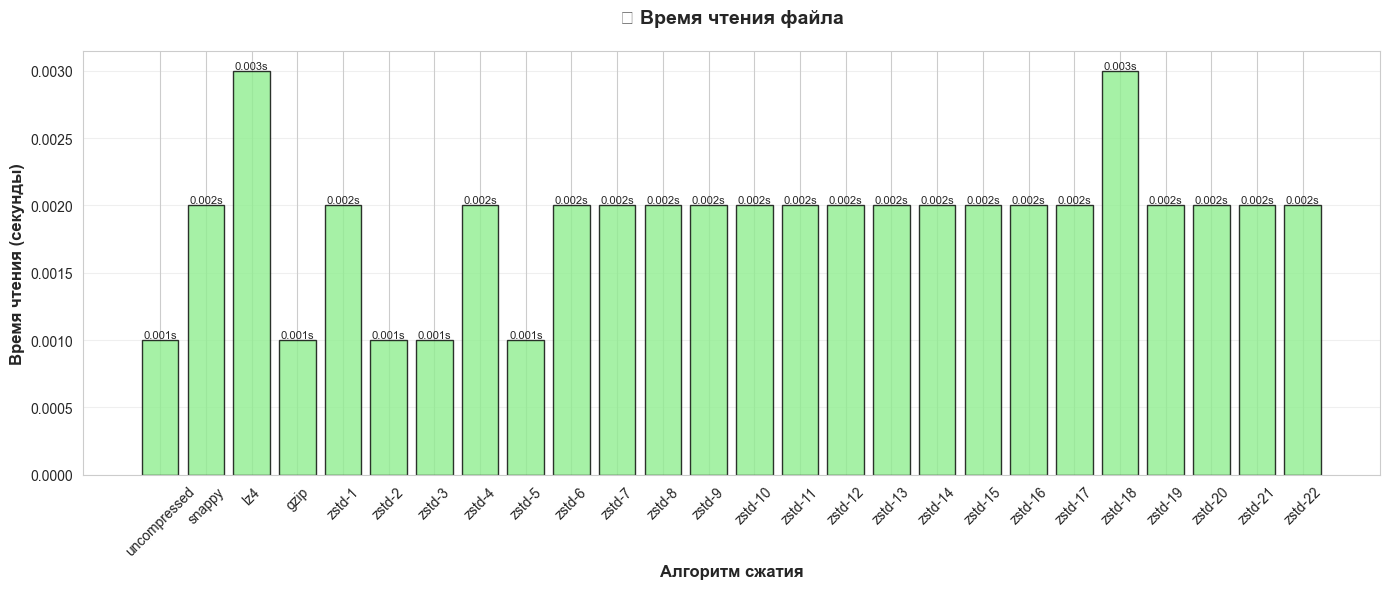

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


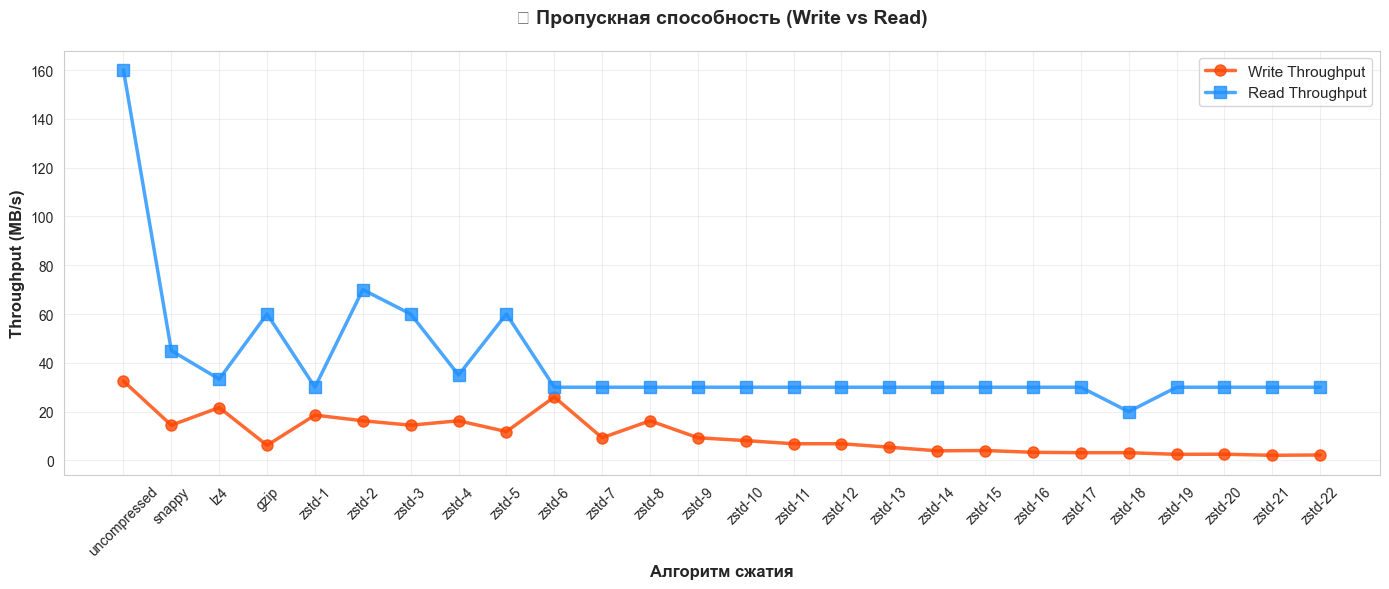

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


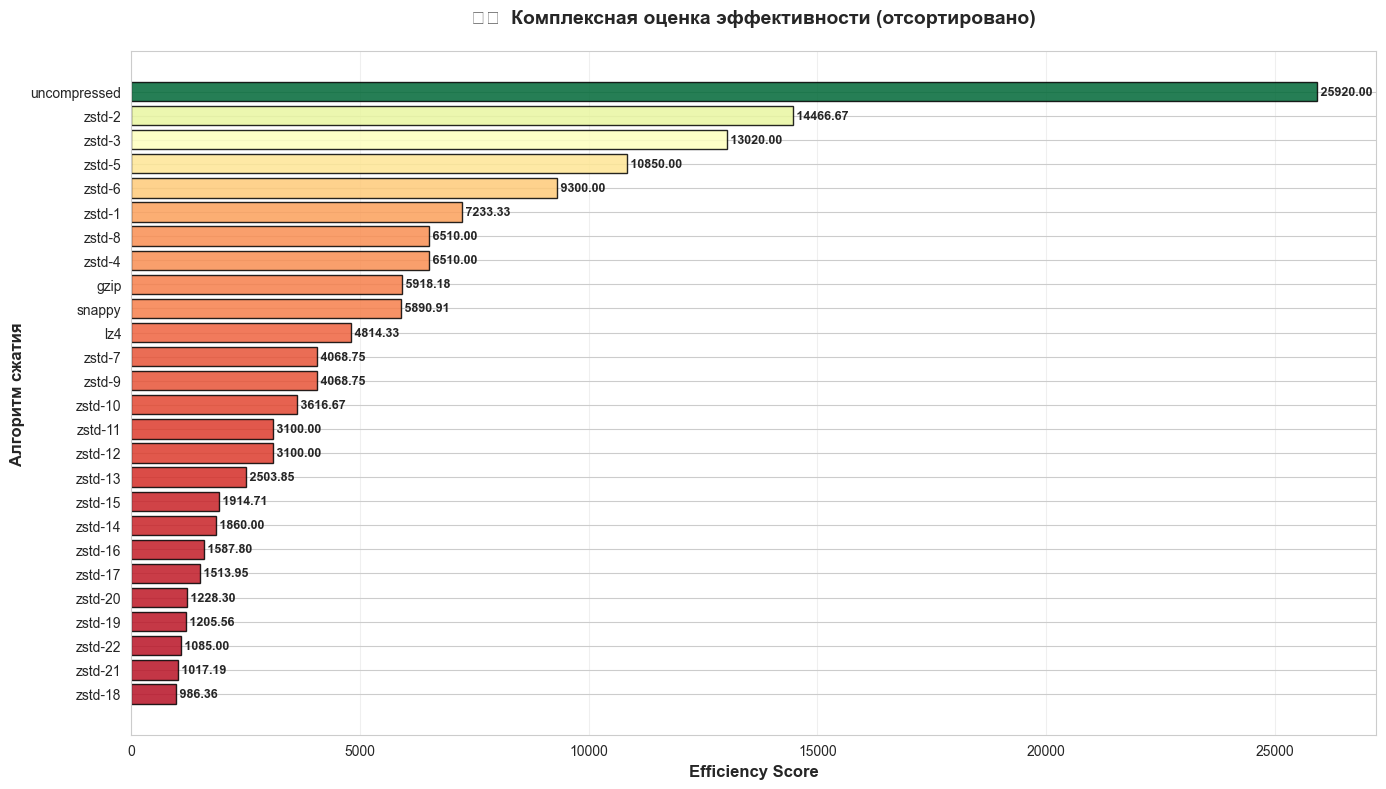


✅ Все графики построены!


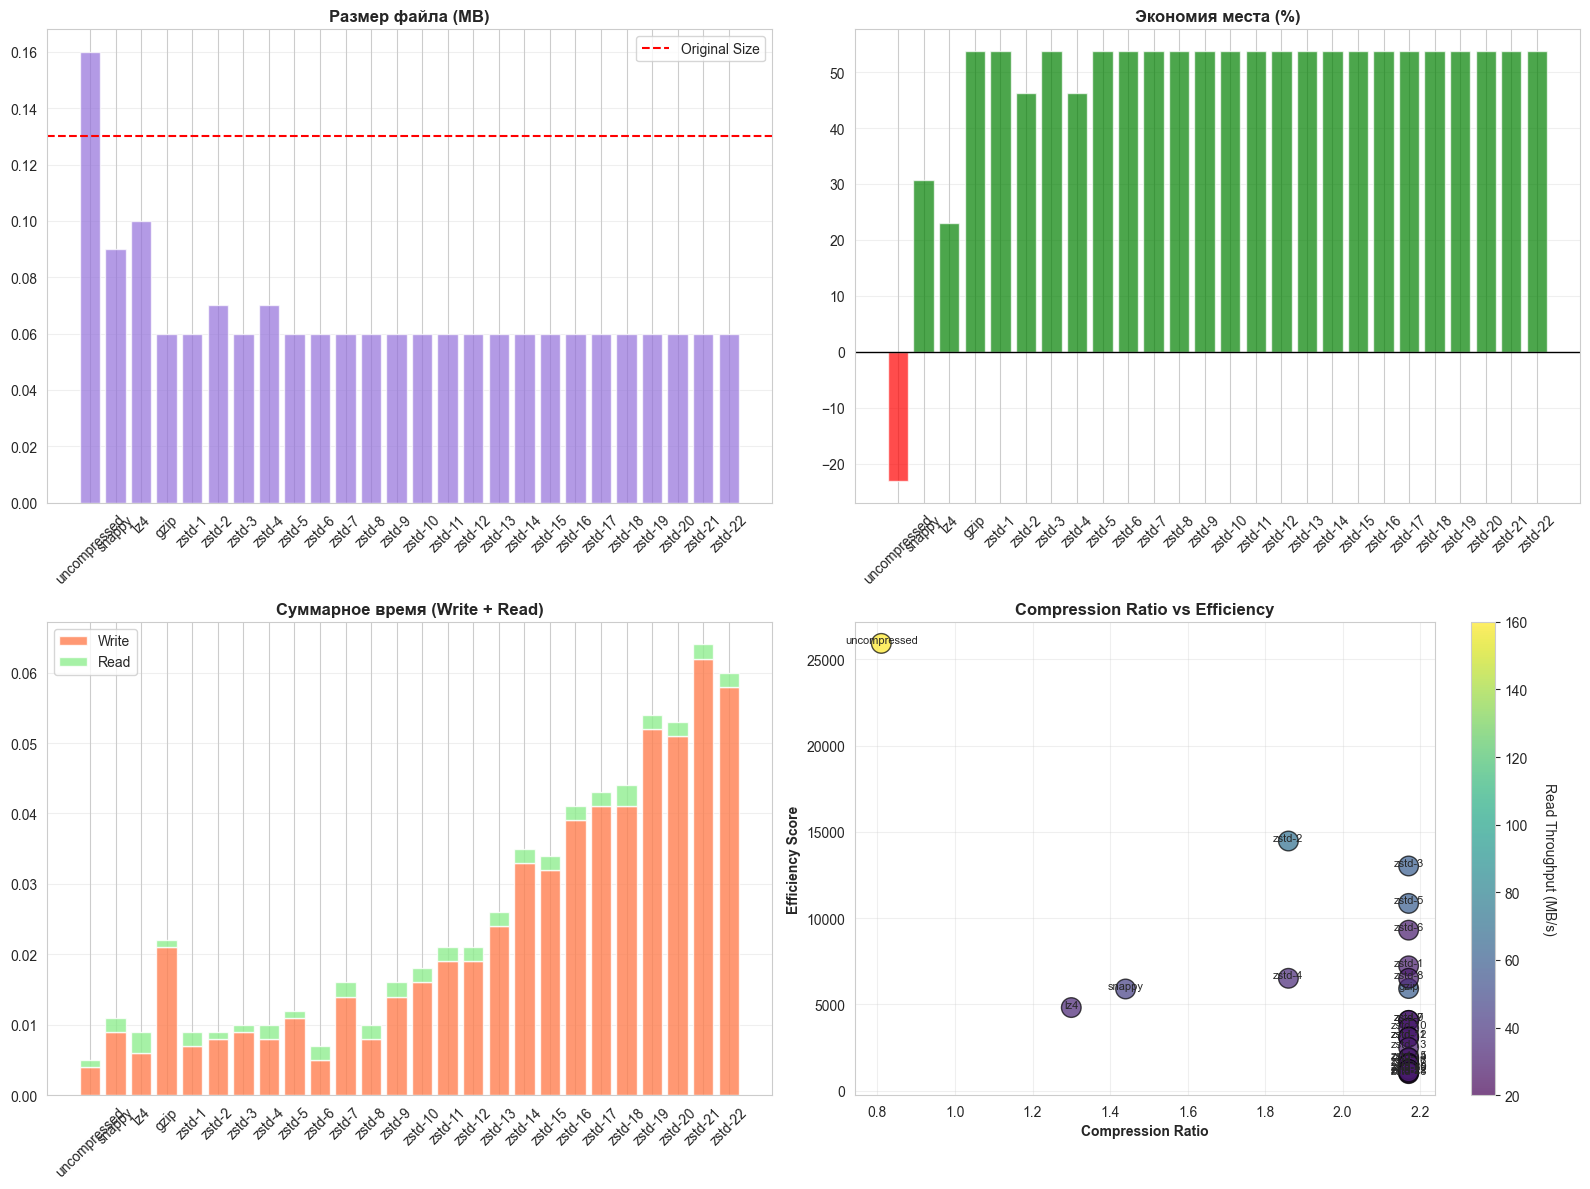


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [4]:
results_df = benchmark_compression_methods(
    source_file='data_1_000.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

display(results_df)

analyze_results(results_df)

plot_compression_analysis(results_df)

plot_comparison_summary(results_df)

save_results(results_df, 'compression_benchmark.csv')


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data_10_000.parquet
📏 Размер: 1.03 MB
📈 Записей: 10,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 1.1 MB (ratio: 0.94x, --6.8%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.74 MB (ratio: 1.39x, -28.2%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.76 MB (ratio: 1.36x, -26.2%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.51 MB (ratio: 2.02x, -50.5%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.51 MB (ratio: 2.02x, -50.5%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.5 MB (ratio: 2.06x, -51.5%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.51 MB (ratio: 2.02x, -50.5%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 0.51 MB (ratio: 2.02x, -

,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,0.006,0.8,0.8,0.0,0.002,0.000,0.63,1.7,0.0,...,171.67,550.00,64625.00,10000,1,benchmark_results/uncompressed/data.parquet,26.0,1.0,1.0,1.0
1,snappy,0.020,0.8,0.8,0.0,0.002,0.001,0.40,1.0,0.0,...,51.50,370.00,23377.27,10000,1,benchmark_results/snappy/data.parquet,24.0,3.0,3.0,3.0
2,lz4,0.025,0.7,0.7,0.0,0.002,0.000,0.67,1.6,0.0,...,41.20,380.00,19140.74,10000,1,benchmark_results/lz4/data.parquet,25.0,2.0,5.0,5.0
3,gzip,0.077,0.4,0.4,0.0,0.002,0.000,0.73,1.8,0.0,...,13.38,255.00,6520.25,10000,1,benchmark_results/gzip/data.parquet,21.5,5.5,16.0,16.0
4,zstd-1,0.022,1.5,1.5,0.0,0.002,0.000,0.67,1.7,0.0,...,46.82,255.00,21462.50,10000,1,benchmark_results/zstd_lvl1/data.parquet,21.5,5.5,4.0,4.0
5,zstd-2,0.019,1.5,1.5,0.0,0.002,0.000,0.73,1.9,0.0,...,54.21,250.00,24523.81,10000,1,benchmark_results/zstd_lvl2/data.parquet,18.5,8.5,2.0,2.0
6,zstd-3,0.026,1.6,1.6,0.0,0.002,0.001,0.70,1.8,0.0,...,39.62,255.00,18396.43,10000,1,benchmark_results/zstd_lvl3/data.parquet,21.5,5.5,6.0,6.0
7,zstd-4,0.032,1.7,1.7,0.0,0.002,0.001,0.67,1.7,0.0,...,32.19,255.00,15150.00,10000,1,benchmark_results/zstd_lvl4/data.parquet,21.5,5.5,8.0,8.0
8,zstd-5,0.035,1.6,1.6,0.0,0.002,0.000,0.73,2.0,0.0,...,29.43,250.00,13918.92,10000,1,benchmark_results/zstd_lvl5/data.parquet,18.5,8.5,9.0,9.0
9,zstd-6,0.036,1.4,1.4,0.0,0.002,0.000,0.67,1.7,0.0,...,28.61,245.00,13539.47,10000,1,benchmark_results/zstd_lvl6/data.parquet,15.0,12.0,10.0,10.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: zstd-16
   Compression Ratio: 2.24x
   Размер: 0.46 MB
   Экономия: 55.3%

⚡ Самая быстрая запись: uncompressed
   Throughput: 171.67 MB/s
   Время: 0.006 s

🚀 Самое быстрое чтение: uncompressed
   Throughput: 550.0 MB/s
   Время: 0.002 s

⚖️  Лучший баланс (Efficiency Score): uncompressed
   Score: 64625.0
   Compression Ratio: 0.94x
   Read Throughput: 550.0 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): uncompressed
   • Warm Storage (баланс): uncompressed
   • Cold Storage (размер важнее): zstd-16



/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


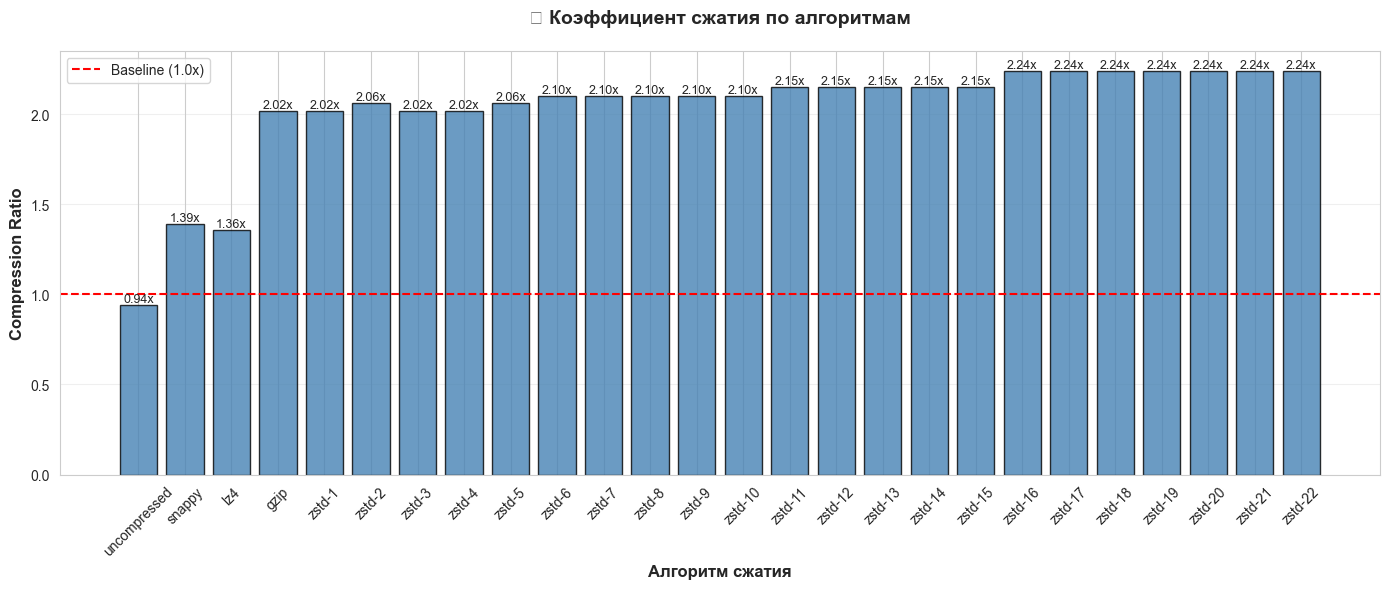

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


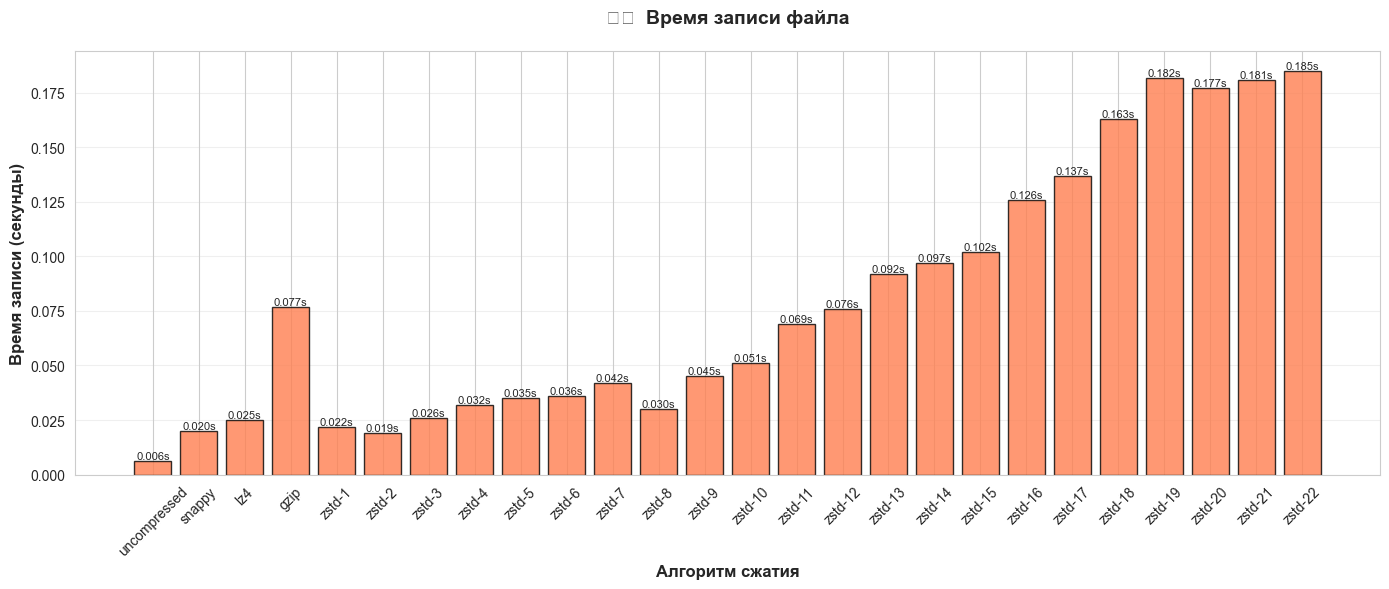

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


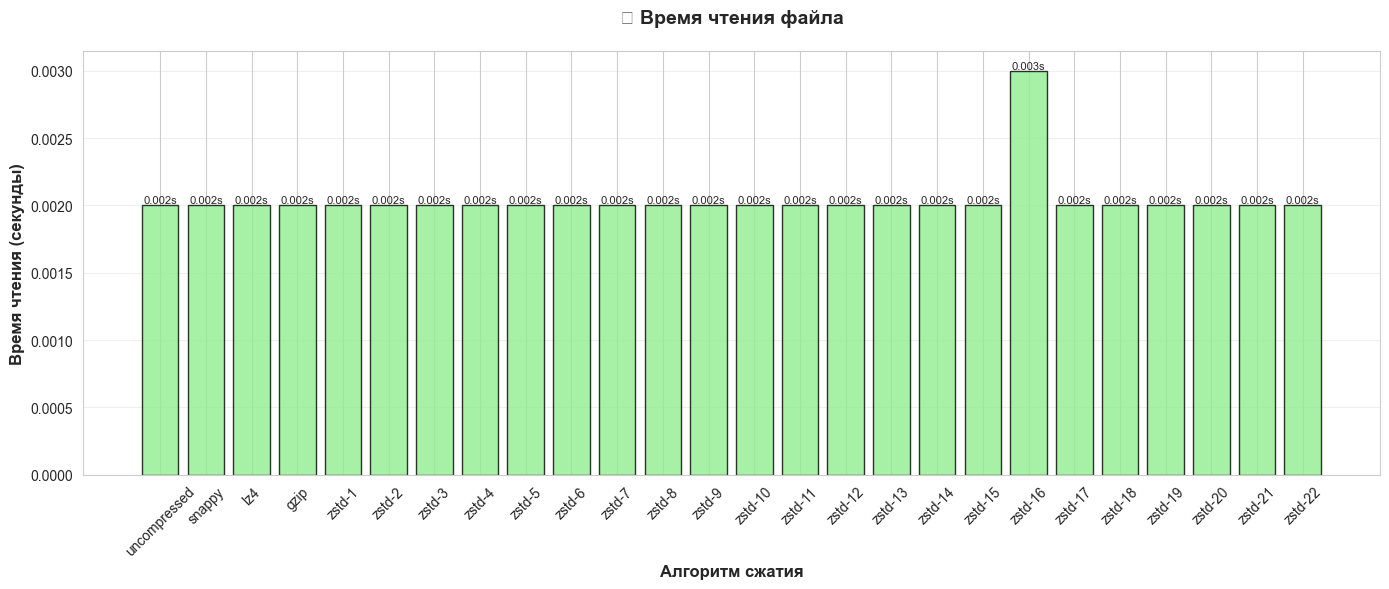

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


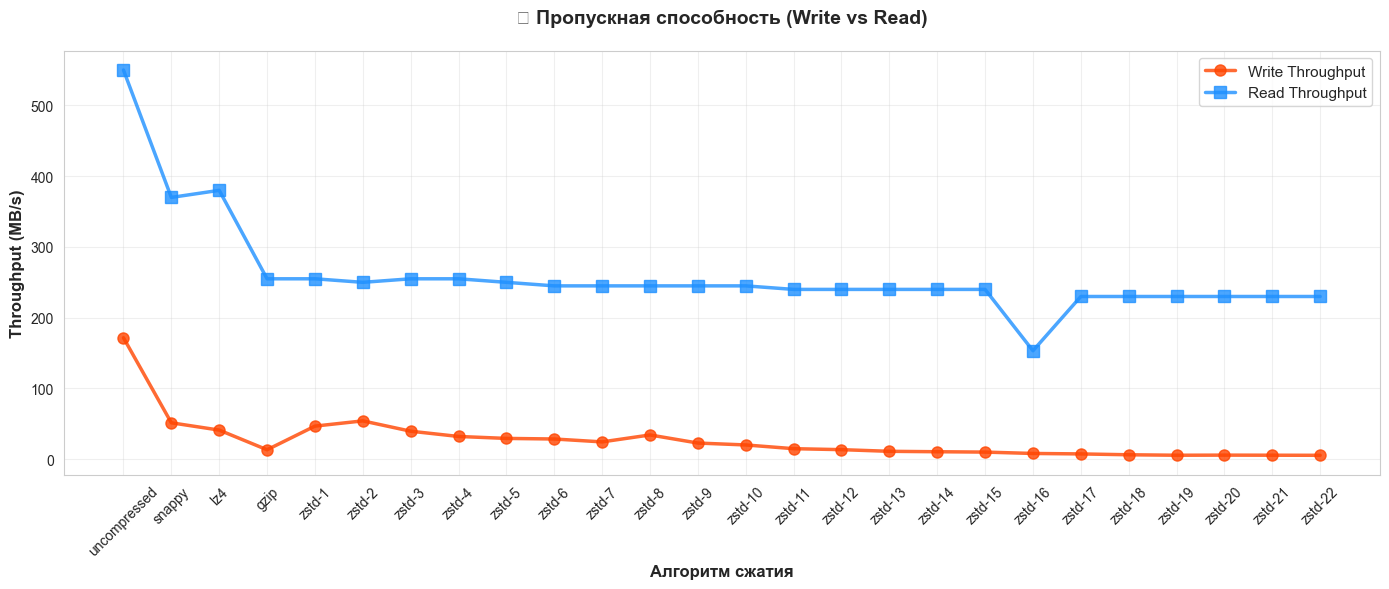

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


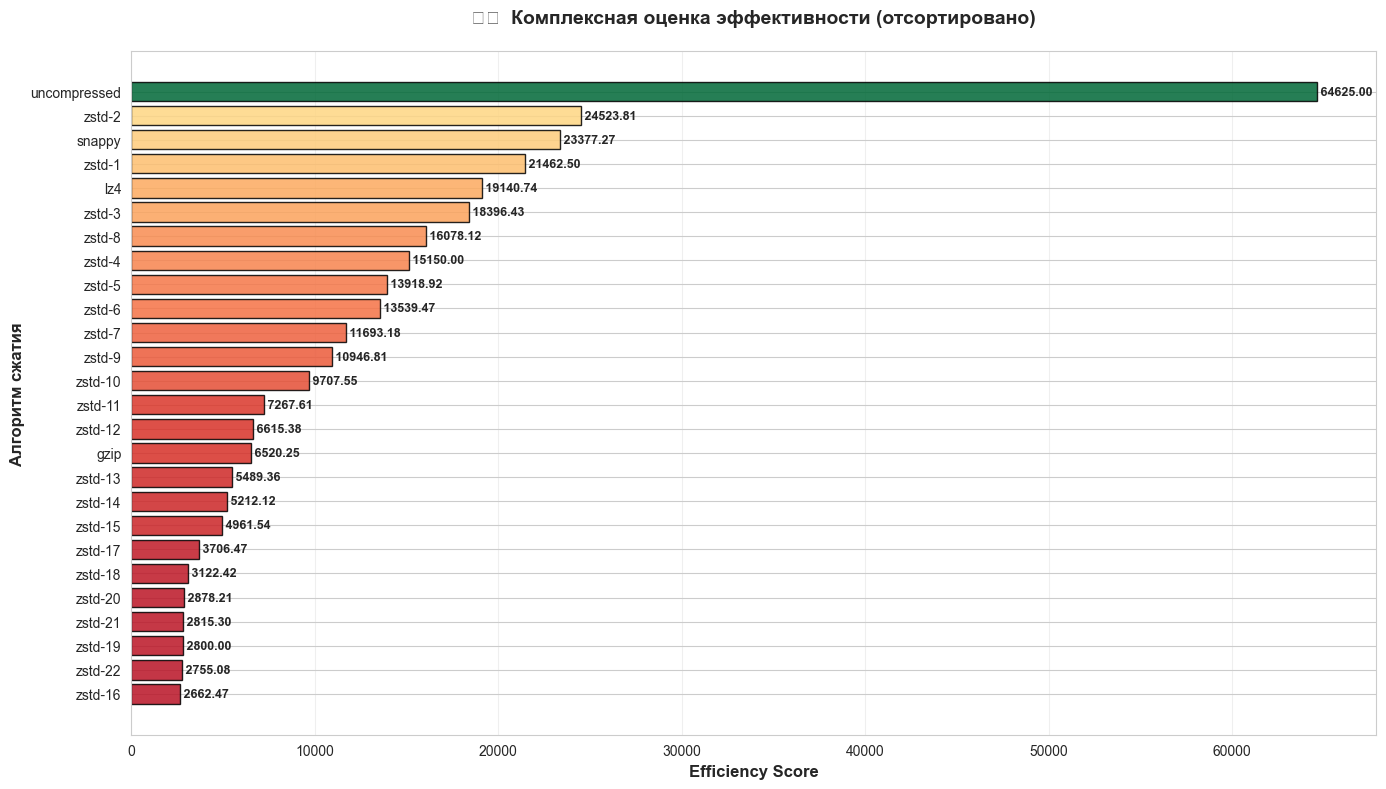


✅ Все графики построены!


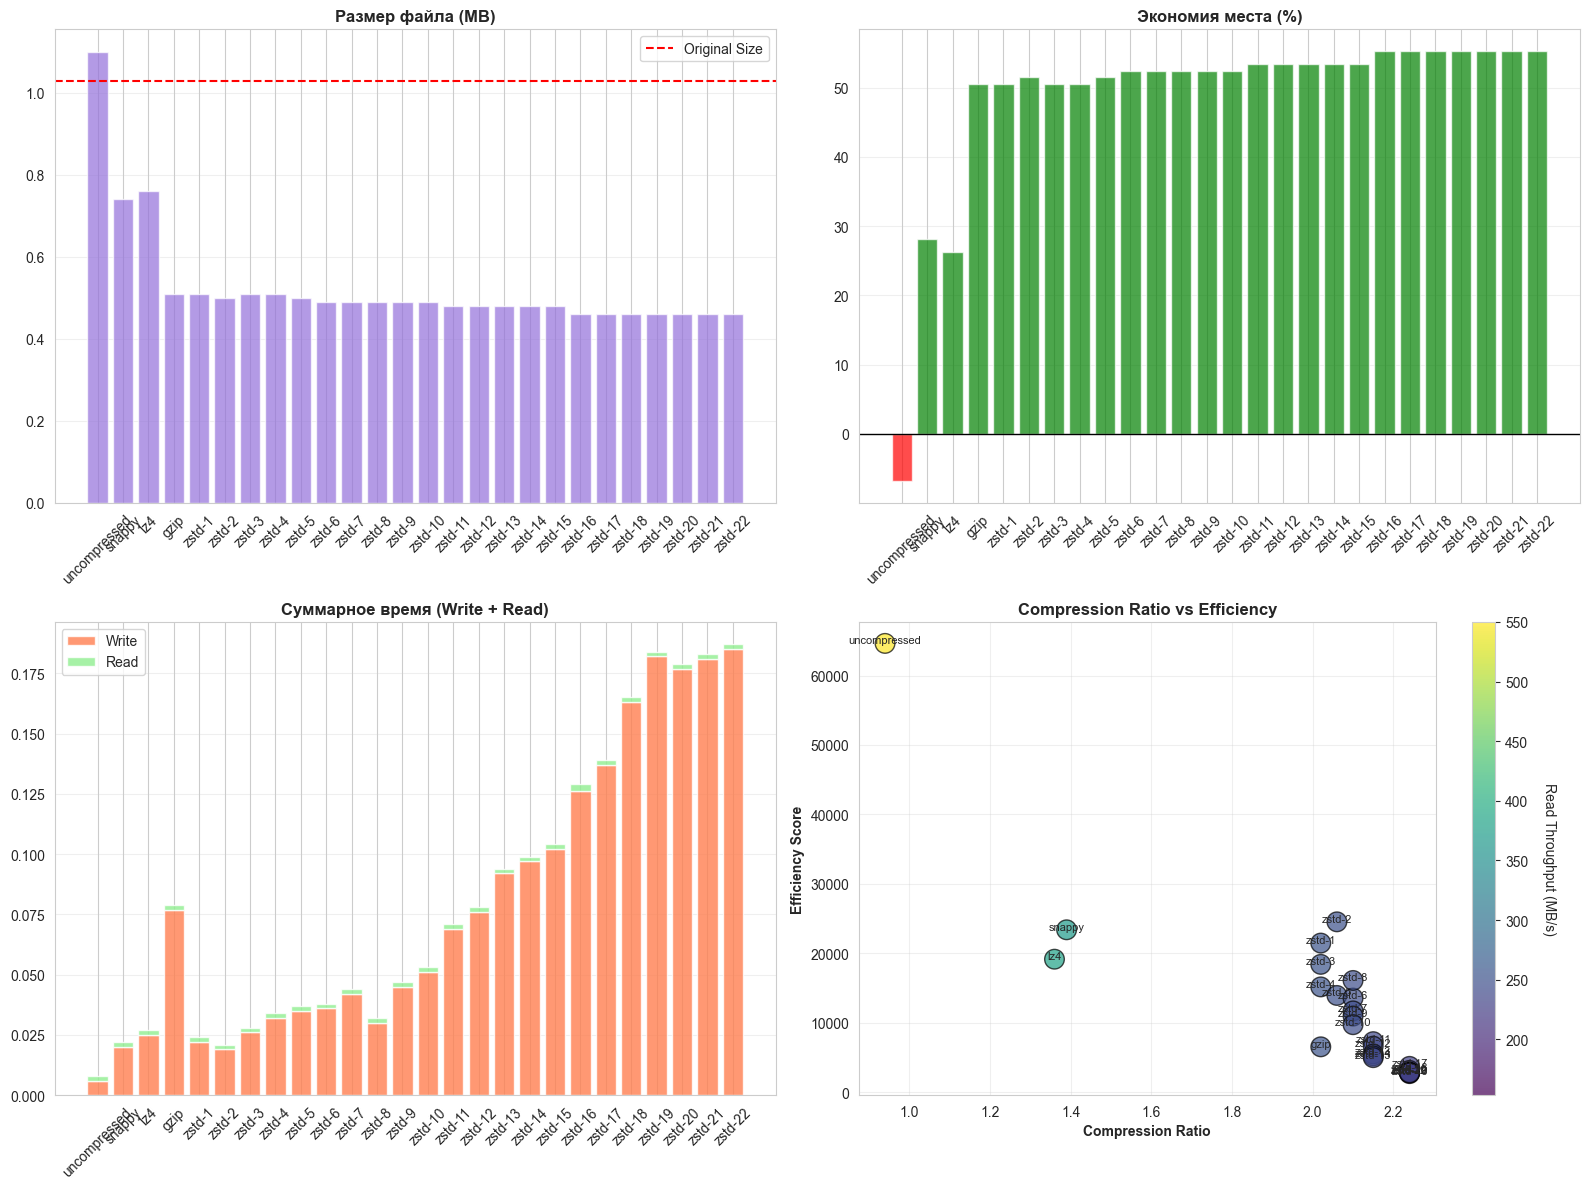


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [5]:
results_df = benchmark_compression_methods(
    source_file='data_10_000.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

display(results_df)

analyze_results(results_df)

plot_compression_analysis(results_df)

plot_comparison_summary(results_df)

save_results(results_df, 'compression_benchmark.csv')


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data_100_000.parquet
📏 Размер: 9.07 MB
📈 Записей: 100,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 8.57 MB (ratio: 1.06x, -5.5%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 6.46 MB (ratio: 1.4x, -28.8%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 6.71 MB (ratio: 1.35x, -26.0%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4.69 MB (ratio: 1.93x, -48.3%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4.55 MB (ratio: 1.99x, -49.8%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4.56 MB (ratio: 1.99x, -49.7%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4.59 MB (ratio: 1.98x, -49.4%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4.65 MB (ratio: 1.95x,

,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,0.034,0.5,0.5,0.0,0.002,0.000,0.47,1.2,0.0,...,266.76,4285.0,126169.44,100000,1,benchmark_results/uncompressed/data.parquet,26.0,1.0,1.0,1.0
1,snappy,0.073,0.5,0.5,0.0,0.002,0.001,0.67,1.8,0.0,...,124.25,3230.0,60293.33,100000,1,benchmark_results/snappy/data.parquet,24.0,3.0,2.0,2.0
2,lz4,0.077,0.4,0.4,0.0,0.002,0.001,0.67,1.7,0.0,...,117.79,3355.0,57332.28,100000,1,benchmark_results/lz4/data.parquet,25.0,2.0,3.0,3.0
3,gzip,0.283,0.1,0.1,0.0,0.002,0.001,0.53,1.4,0.0,...,32.05,2345.0,15880.18,100000,1,benchmark_results/gzip/data.parquet,23.0,4.0,16.0,16.0
4,zstd-1,0.078,0.4,0.4,0.0,0.002,0.000,0.57,1.5,0.0,...,116.28,2275.0,56590.62,100000,1,benchmark_results/zstd_lvl1/data.parquet,18.5,9.0,4.0,4.0
5,zstd-2,0.083,0.4,0.4,0.0,0.002,0.000,0.60,1.6,0.0,...,109.28,2280.0,53378.82,100000,1,benchmark_results/zstd_lvl2/data.parquet,18.5,8.0,5.0,5.0
6,zstd-3,0.086,0.4,0.4,0.0,0.002,0.001,0.53,1.4,0.0,...,105.47,2295.0,51637.50,100000,1,benchmark_results/zstd_lvl3/data.parquet,20.0,7.0,6.0,6.0
7,zstd-4,0.092,0.4,0.4,0.0,0.002,0.000,0.63,1.6,0.0,...,98.59,2325.0,48231.38,100000,1,benchmark_results/zstd_lvl4/data.parquet,22.0,5.0,7.0,7.0
8,zstd-5,0.105,0.1,0.1,0.0,0.002,0.000,0.63,1.6,0.0,...,86.38,2300.0,42345.79,100000,1,benchmark_results/zstd_lvl5/data.parquet,21.0,6.0,8.0,8.0
9,zstd-6,0.117,0.1,0.1,0.0,0.002,0.000,0.60,1.6,0.0,...,77.52,2270.0,38151.26,100000,1,benchmark_results/zstd_lvl6/data.parquet,16.5,10.0,9.0,9.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: zstd-16
   Compression Ratio: 2.15x
   Размер: 4.22 MB
   Экономия: 53.5%

⚡ Самая быстрая запись: uncompressed
   Throughput: 266.76 MB/s
   Время: 0.034 s

🚀 Самое быстрое чтение: uncompressed
   Throughput: 4285.0 MB/s
   Время: 0.002 s

⚖️  Лучший баланс (Efficiency Score): uncompressed
   Score: 126169.44
   Compression Ratio: 1.06x
   Read Throughput: 4285.0 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): uncompressed
   • Warm Storage (баланс): uncompressed
   • Cold Storage (размер важнее): zstd-16



/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


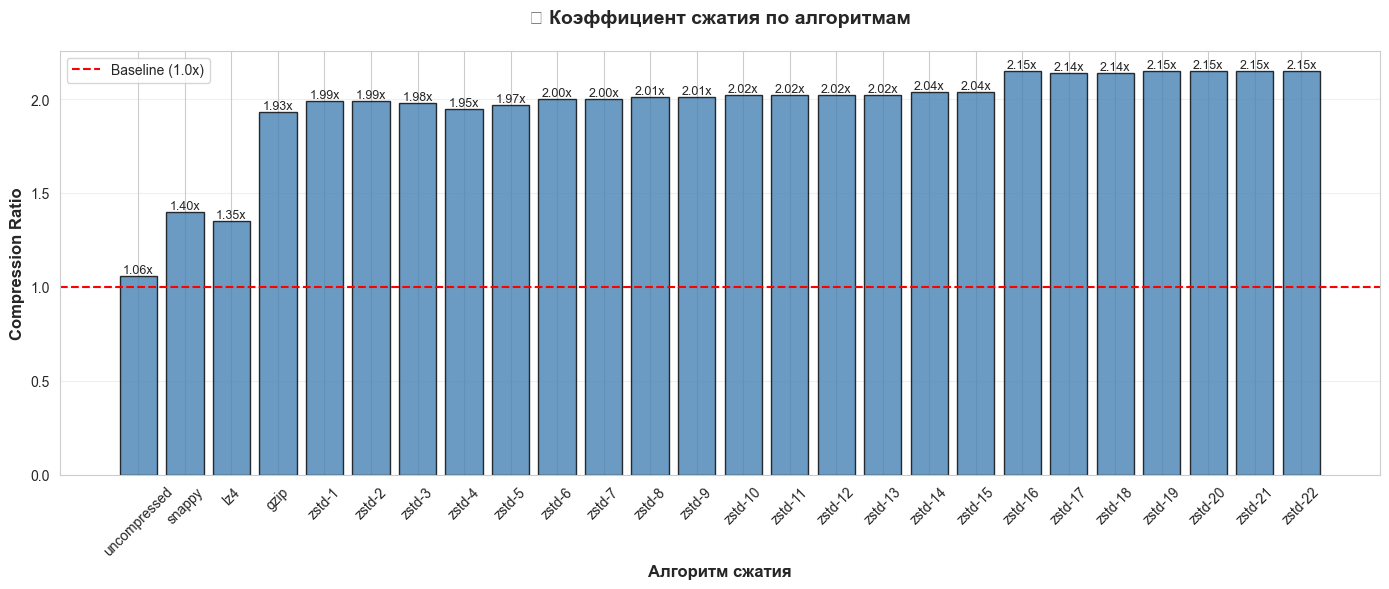

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


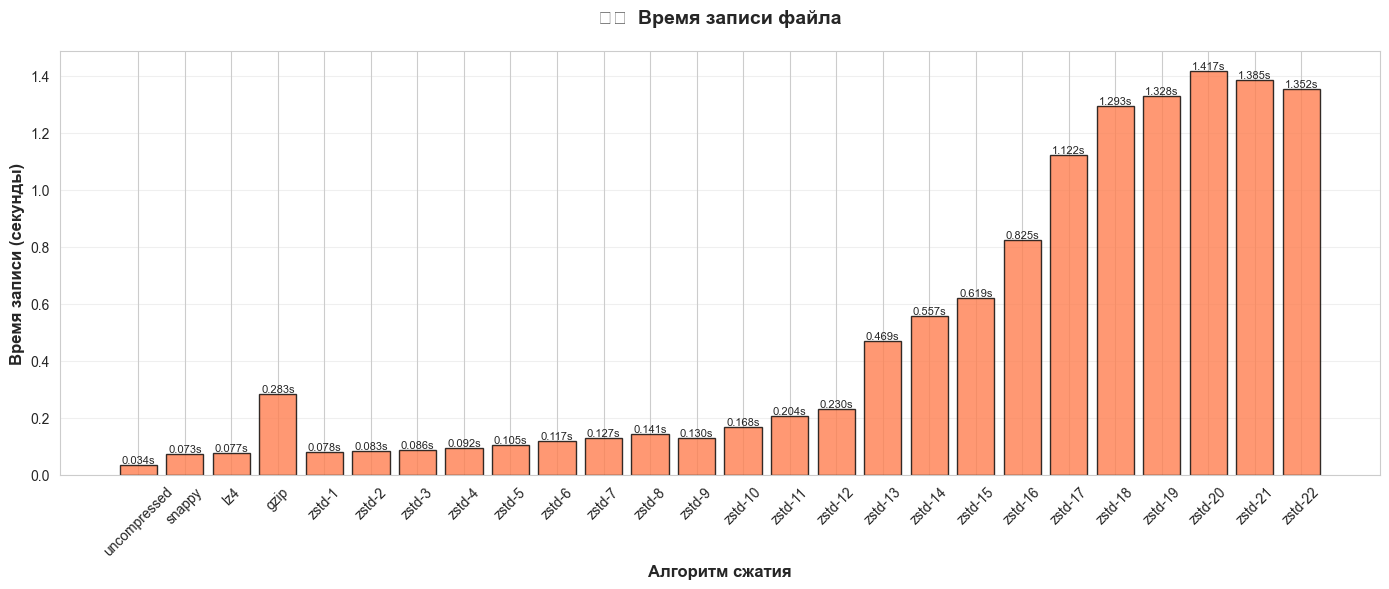

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


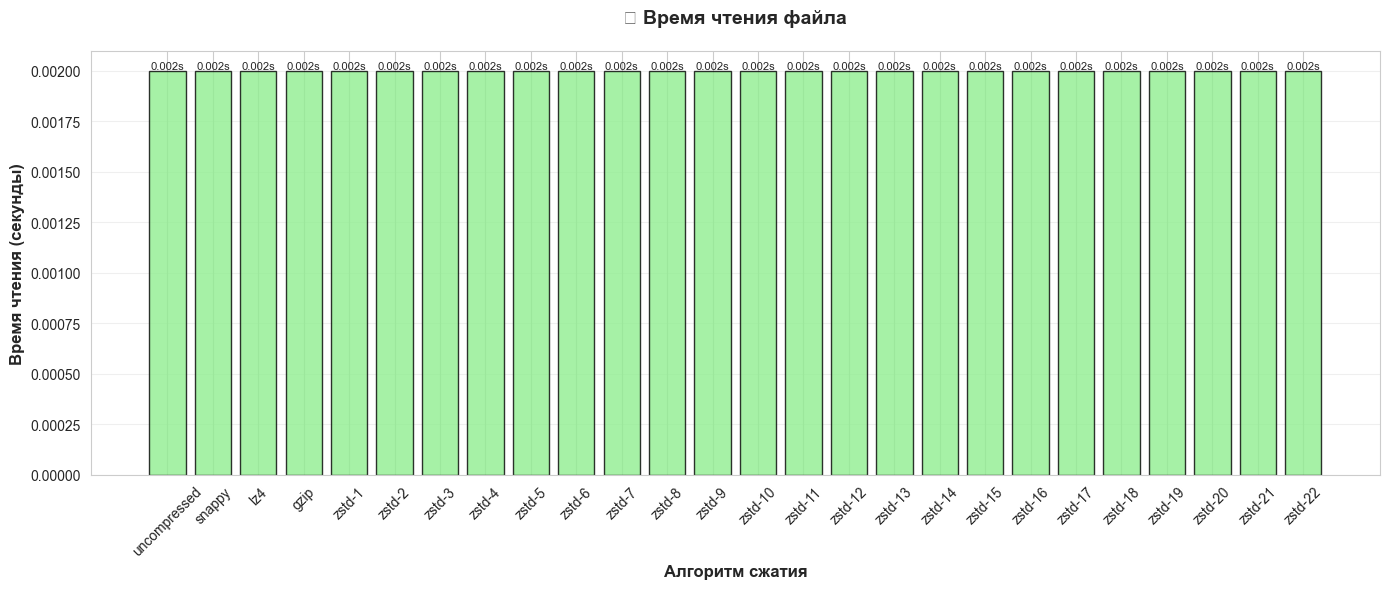

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


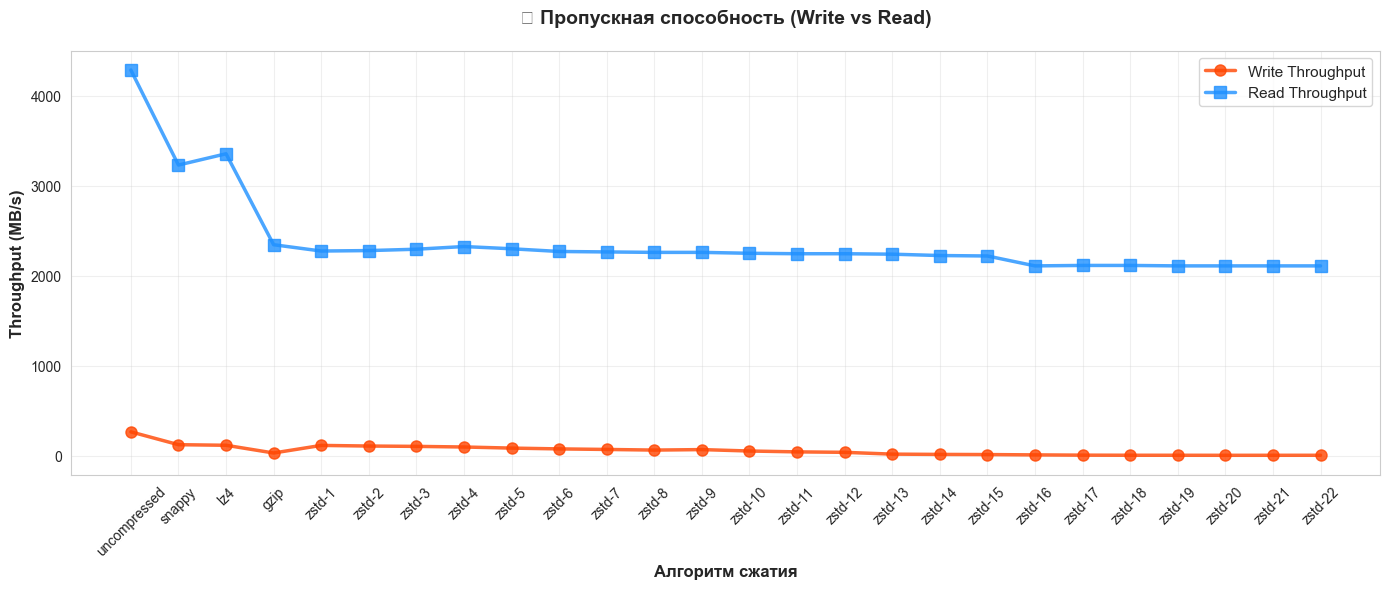

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


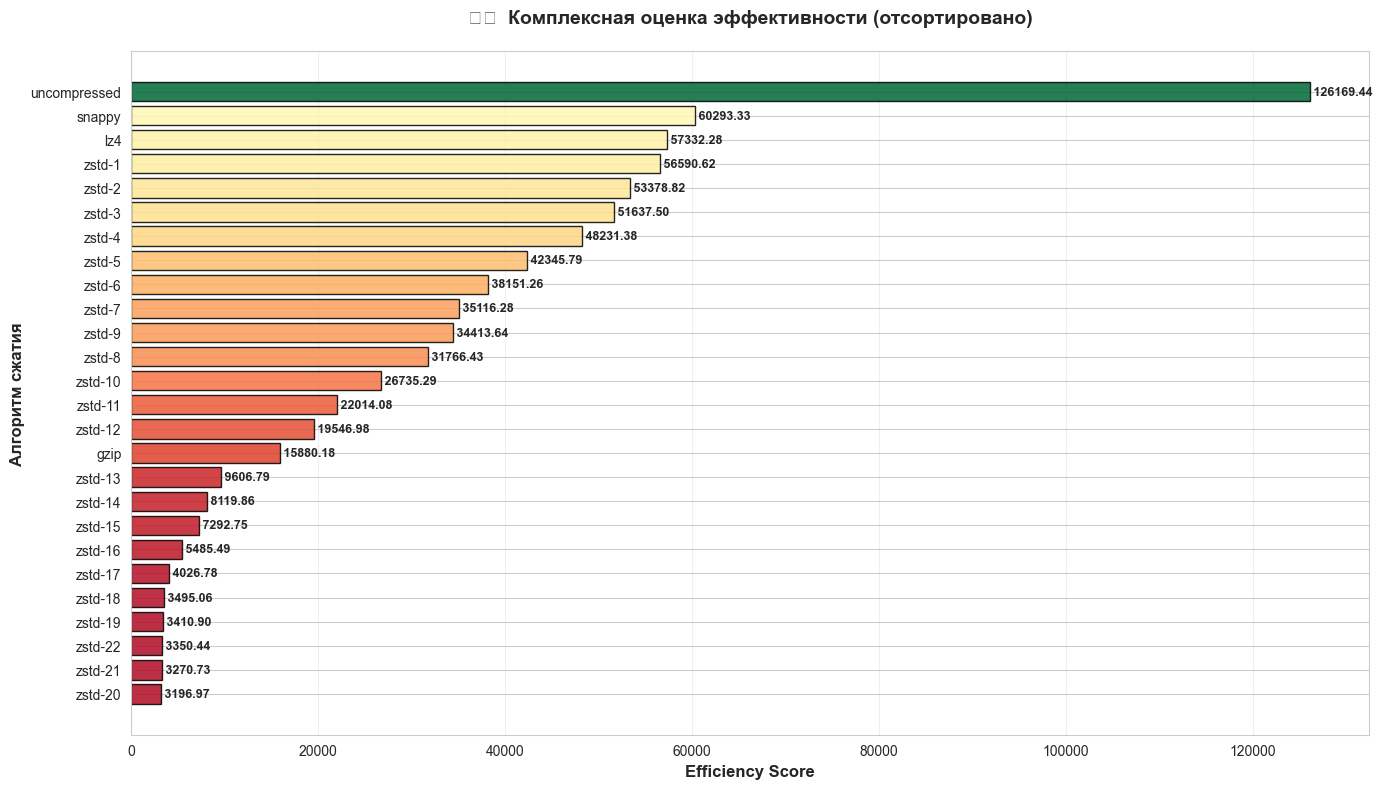


✅ Все графики построены!


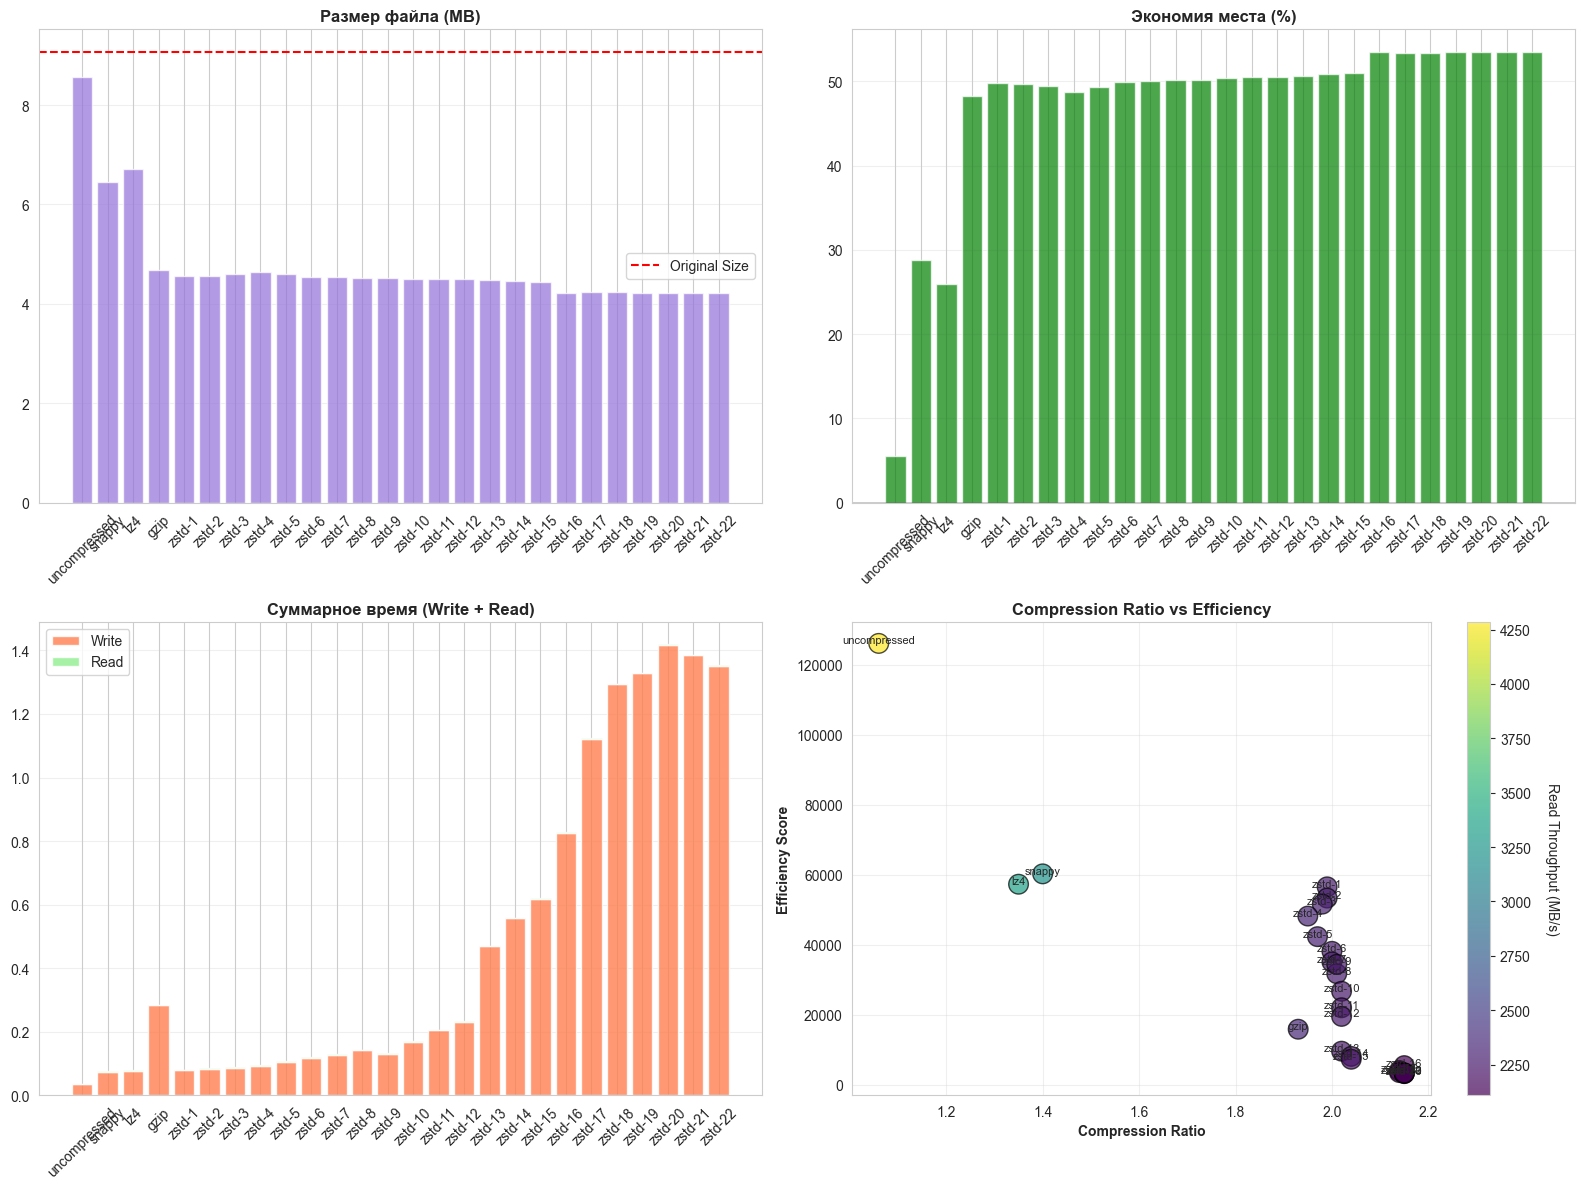


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [6]:
results_df = benchmark_compression_methods(
    source_file='data_100_000.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

display(results_df)

analyze_results(results_df)

plot_compression_analysis(results_df)

plot_comparison_summary(results_df)

save_results(results_df, 'compression_benchmark.csv')


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data_1_000_000.parquet
📏 Размер: 85.03 MB
📈 Записей: 1,000,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 85.82 MB (ratio: 0.99x, --0.9%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 64.59 MB (ratio: 1.32x, -24.0%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 67.09 MB (ratio: 1.27x, -21.1%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 46.87 MB (ratio: 1.81x, -44.9%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 45.48 MB (ratio: 1.87x, -46.5%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 45.61 MB (ratio: 1.86x, -46.4%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 45.93 MB (ratio: 1.85x, -46.0%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 46.51 MB

,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,0.196,0.1,0.1,0.01,0.003,0.002,0.53,1.4,0.0,...,433.83,28606.67,142314.59,1000000,1,benchmark_results/uncompressed/data.parquet,26.0,2.0,1.0,2.0
1,snappy,0.247,0.1,0.1,0.00,0.002,0.003,0.63,1.7,0.0,...,344.25,32295.00,171202.41,1000000,1,benchmark_results/snappy/data.parquet,24.0,1.0,2.0,1.0
2,lz4,0.254,0.1,0.1,0.00,0.004,0.002,0.70,1.8,0.0,...,334.76,16772.50,82562.31,1000000,1,benchmark_results/lz4/data.parquet,25.0,6.0,4.0,9.0
3,gzip,0.579,0.1,0.1,0.00,0.003,0.001,0.60,1.6,0.0,...,146.86,15623.33,48588.02,1000000,1,benchmark_results/gzip/data.parquet,23.0,7.0,15.0,14.0
4,zstd-1,0.249,0.1,0.1,0.00,0.004,0.000,0.60,1.5,0.0,...,341.49,11370.00,84039.13,1000000,1,benchmark_results/zstd_lvl1/data.parquet,17.5,22.0,3.0,8.0
5,zstd-2,0.262,0.1,0.1,0.00,0.004,0.001,0.67,1.6,0.0,...,324.54,11402.50,79731.77,1000000,1,benchmark_results/zstd_lvl2/data.parquet,19.0,21.0,6.0,11.0
6,zstd-3,0.261,0.1,0.1,0.00,0.004,0.002,0.57,1.5,0.0,...,325.79,11482.50,80160.85,1000000,1,benchmark_results/zstd_lvl3/data.parquet,20.5,20.0,5.0,10.0
7,zstd-4,0.276,0.1,0.1,0.00,0.003,0.001,0.60,1.6,0.0,...,308.08,15503.33,101688.51,1000000,1,benchmark_results/zstd_lvl4/data.parquet,22.0,8.0,7.0,4.0
8,zstd-5,0.295,0.1,0.1,0.00,0.003,0.001,0.57,1.5,0.0,...,288.24,15313.33,95065.97,1000000,1,benchmark_results/zstd_lvl5/data.parquet,20.5,9.0,8.0,5.0
9,zstd-6,0.315,0.1,0.1,0.00,0.003,0.001,0.63,1.7,0.0,...,269.94,15123.33,88932.79,1000000,1,benchmark_results/zstd_lvl6/data.parquet,17.5,10.0,9.0,6.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: zstd-16
   Compression Ratio: 2.02x
   Размер: 42.16 MB
   Экономия: 50.4%

⚡ Самая быстрая запись: uncompressed
   Throughput: 433.83 MB/s
   Время: 0.196 s

🚀 Самое быстрое чтение: snappy
   Throughput: 32295.0 MB/s
   Время: 0.002 s

⚖️  Лучший баланс (Efficiency Score): snappy
   Score: 171202.41
   Compression Ratio: 1.32x
   Read Throughput: 32295.0 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): snappy
   • Warm Storage (баланс): snappy
   • Cold Storage (размер важнее): zstd-16



/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


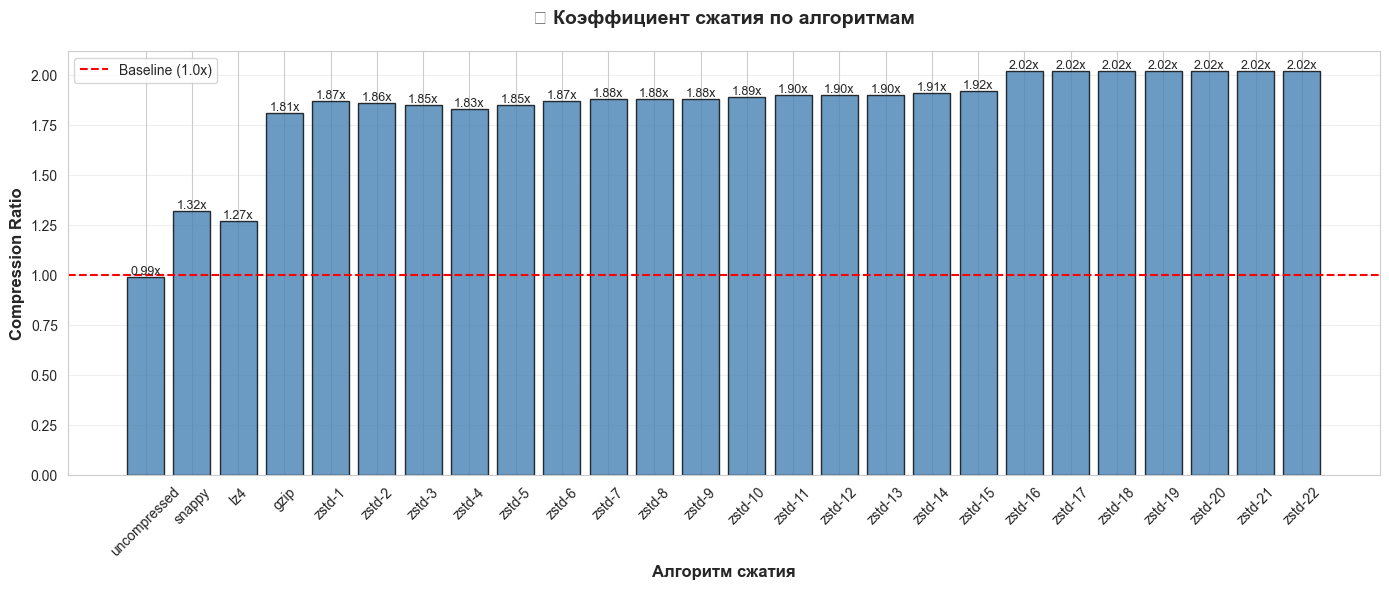

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


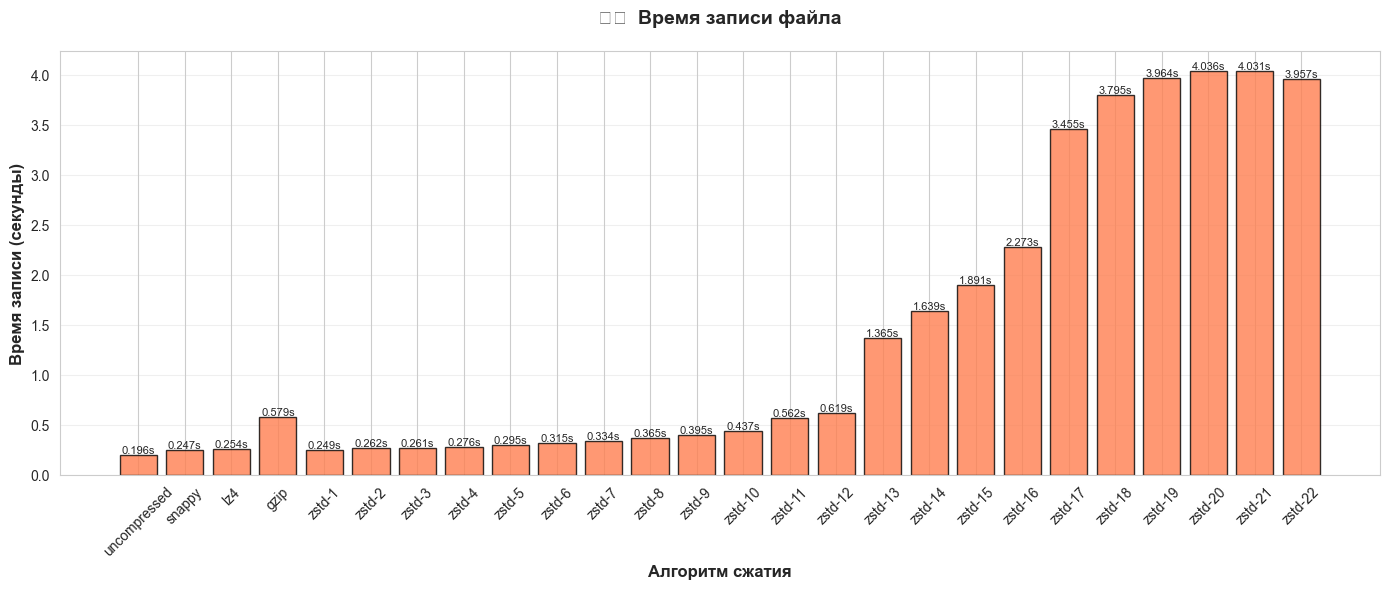

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


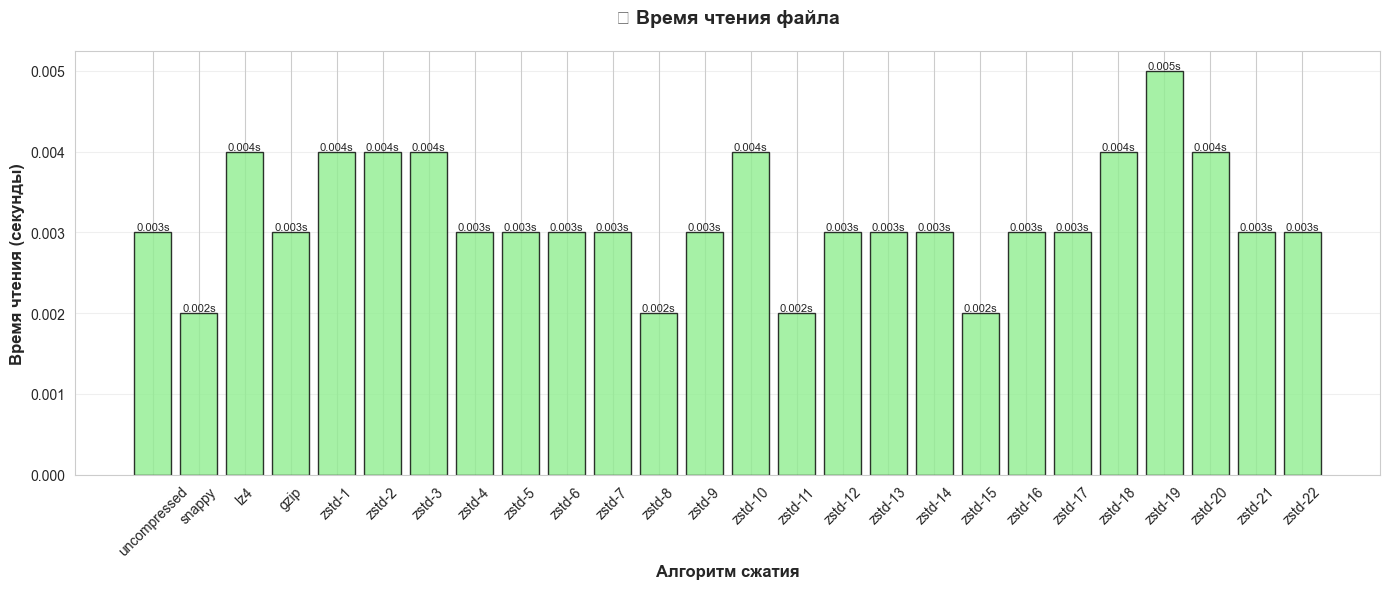

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


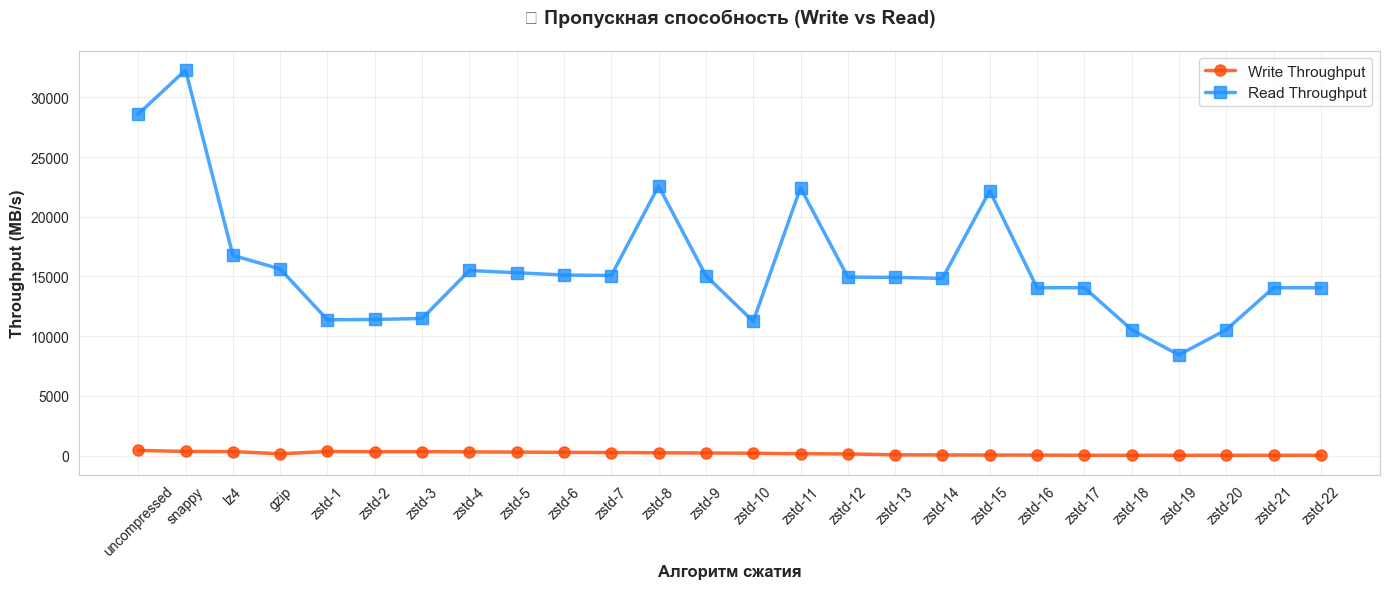

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


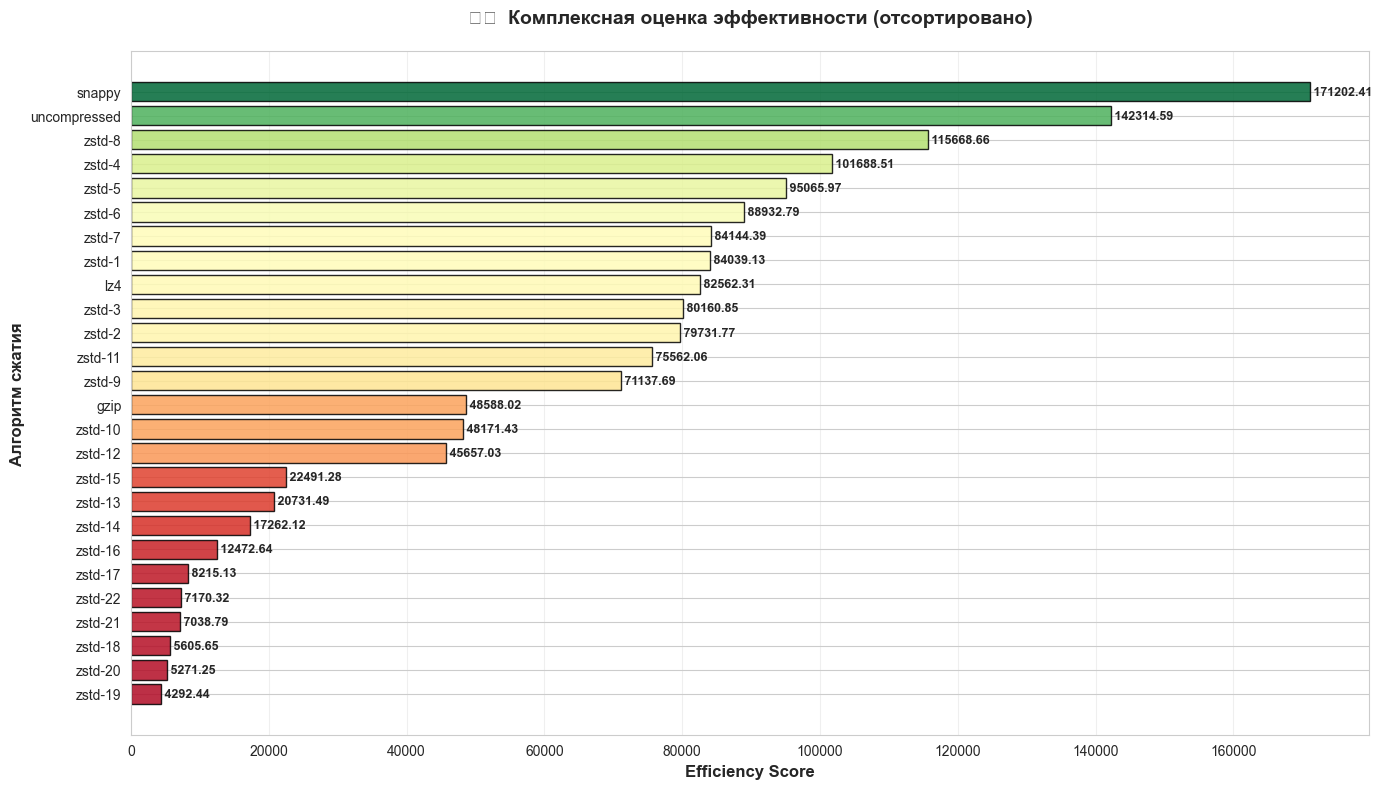


✅ Все графики построены!


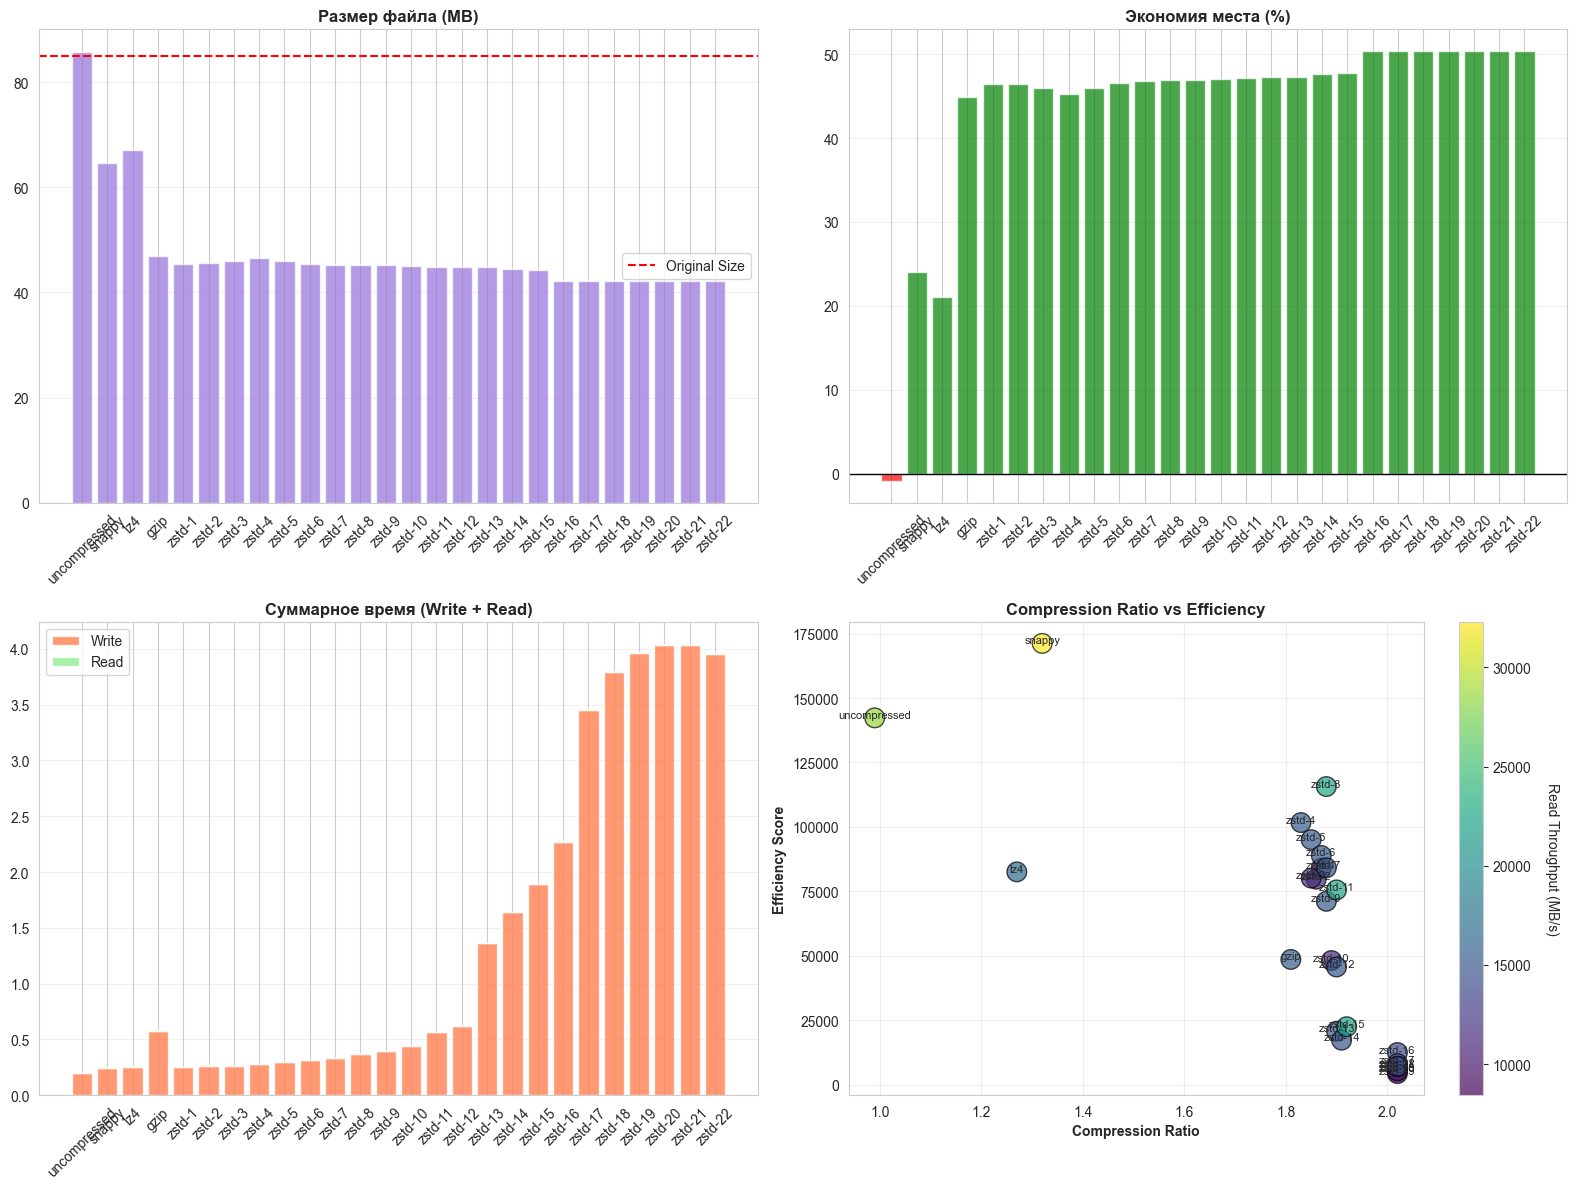


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [7]:
results_df = benchmark_compression_methods(
    source_file='data_1_000_000.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

display(results_df)

analyze_results(results_df)

plot_compression_analysis(results_df)

plot_comparison_summary(results_df)

save_results(results_df, 'compression_benchmark.csv')


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data_10_000_000.parquet
📏 Размер: 850.31 MB
📈 Записей: 10,000,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 854.36 MB (ratio: 1.0x, --0.5%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 644.54 MB (ratio: 1.32x, -24.2%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 669.48 MB (ratio: 1.27x, -21.3%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 468.13 MB (ratio: 1.82x, -44.9%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 453.79 MB (ratio: 1.87x, -46.6%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 455.35 MB (ratio: 1.87x, -46.4%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 458.67 MB (ratio: 1.85x, -46.1%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово:

,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,1.617,0.1,0.1,0.01,0.008,0.004,0.77,2.0,0.0,...,525.86,106795.00,65720.00,10000000,1,benchmark_results/uncompressed/data.parquet,26.0,2.0,8.0,10.0
1,snappy,1.197,0.1,0.1,0.00,0.009,0.006,0.60,1.6,0.0,...,710.37,71615.56,78385.19,10000000,1,benchmark_results/snappy/data.parquet,24.0,12.0,2.0,5.0
2,lz4,1.161,0.1,0.1,0.00,0.005,0.002,0.73,1.8,0.0,...,732.39,133896.00,145838.70,10000000,1,benchmark_results/lz4/data.parquet,25.0,1.0,1.0,1.0
3,gzip,3.493,0.1,0.1,0.00,0.006,0.004,0.60,1.6,0.0,...,243.43,78021.67,40582.86,10000000,1,benchmark_results/gzip/data.parquet,23.0,4.0,14.0,13.0
4,zstd-1,1.200,0.1,0.1,0.00,0.006,0.007,0.67,1.7,0.0,...,708.59,75631.67,117272.99,10000000,1,benchmark_results/zstd_lvl1/data.parquet,18.5,7.0,3.0,2.0
5,zstd-2,1.247,0.1,0.1,0.00,0.006,0.002,0.70,1.7,0.0,...,681.88,75891.67,113262.11,10000000,1,benchmark_results/zstd_lvl2/data.parquet,18.5,6.0,4.0,3.0
6,zstd-3,1.280,0.1,0.1,0.00,0.009,0.005,0.67,1.6,0.0,...,664.30,50963.33,73143.65,10000000,1,benchmark_results/zstd_lvl3/data.parquet,20.5,22.0,5.0,6.0
7,zstd-4,1.393,0.1,0.1,0.00,0.006,0.002,0.67,1.6,0.0,...,610.42,77415.00,101264.80,10000000,1,benchmark_results/zstd_lvl4/data.parquet,22.0,5.0,6.0,4.0
8,zstd-5,1.545,0.1,0.1,0.00,0.008,0.004,0.67,1.6,0.0,...,550.36,57342.50,68308.84,10000000,1,benchmark_results/zstd_lvl5/data.parquet,20.5,19.0,7.0,9.0
9,zstd-6,1.737,0.1,0.1,0.00,0.007,0.002,0.80,2.2,0.0,...,489.53,64742.86,69791.62,10000000,1,benchmark_results/zstd_lvl6/data.parquet,16.0,17.0,9.0,8.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: zstd-16
   Compression Ratio: 2.02x
   Размер: 421.19 MB
   Экономия: 50.5%

⚡ Самая быстрая запись: lz4
   Throughput: 732.39 MB/s
   Время: 1.161 s

🚀 Самое быстрое чтение: lz4
   Throughput: 133896.0 MB/s
   Время: 0.005 s

⚖️  Лучший баланс (Efficiency Score): lz4
   Score: 145838.7
   Compression Ratio: 1.27x
   Read Throughput: 133896.0 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): lz4
   • Warm Storage (баланс): lz4
   • Cold Storage (размер важнее): zstd-16



/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


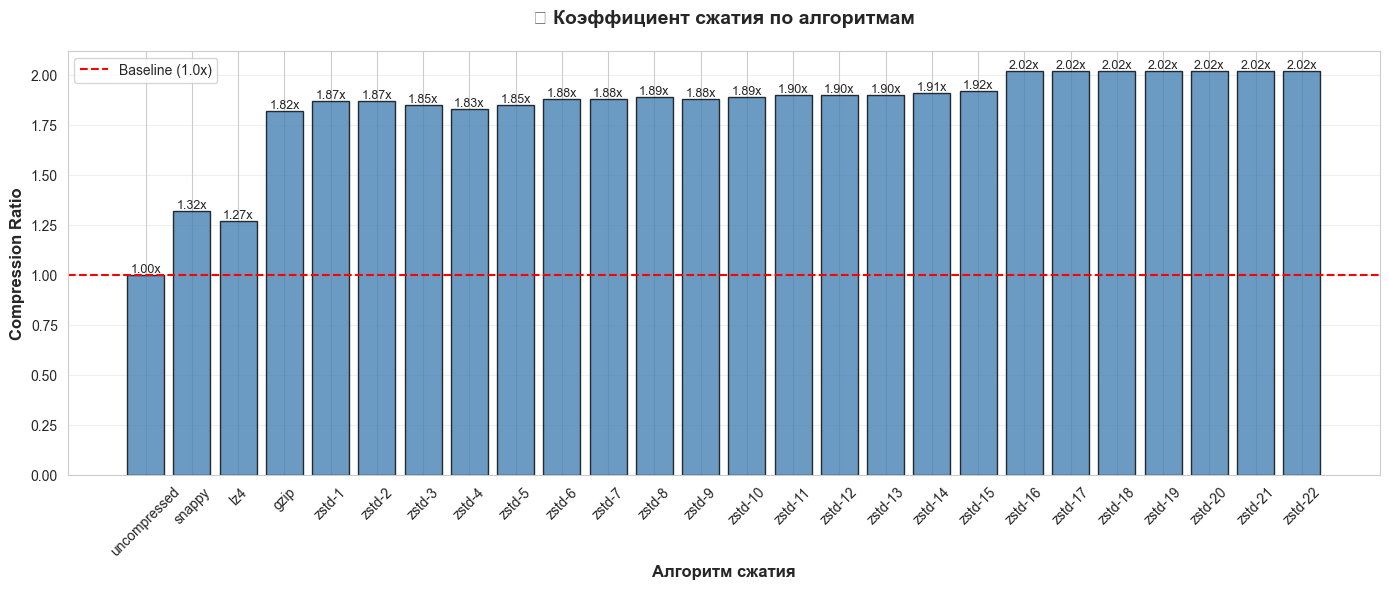

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


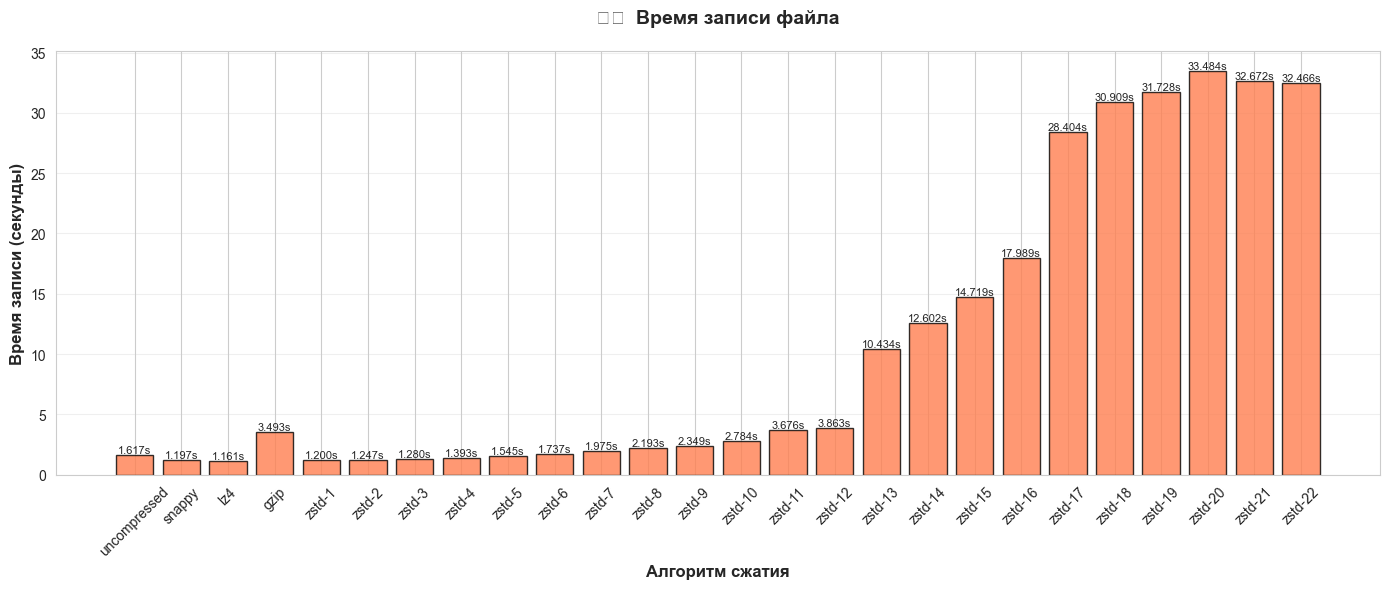

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


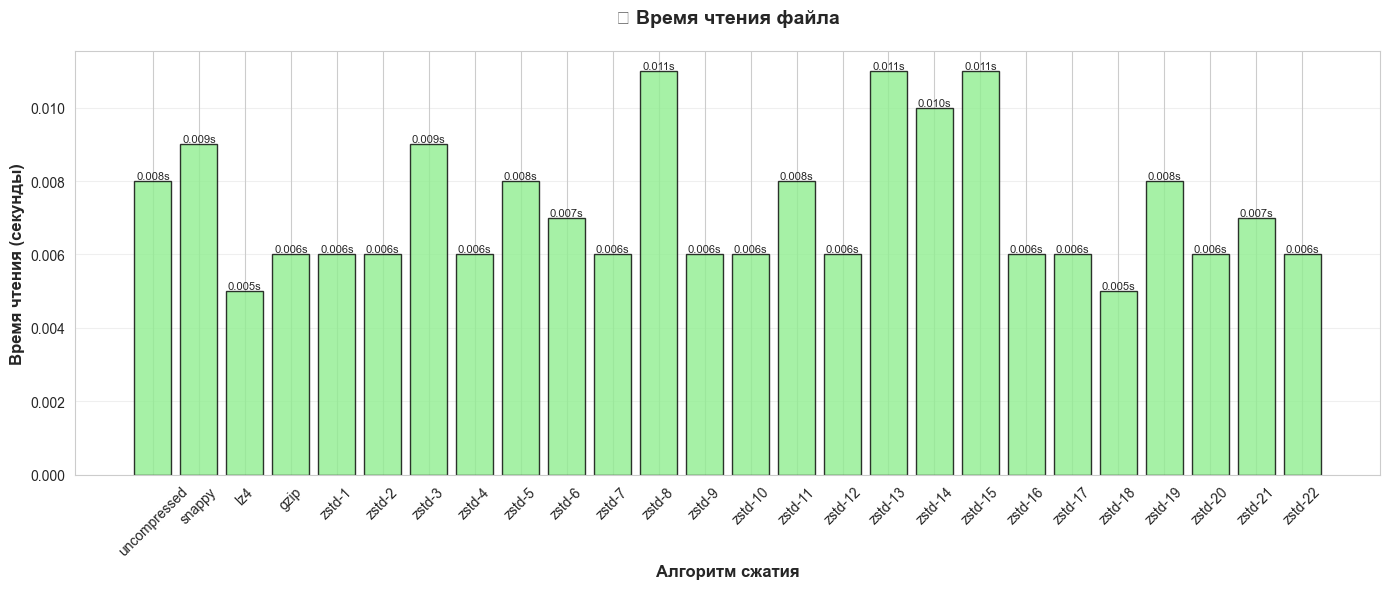

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


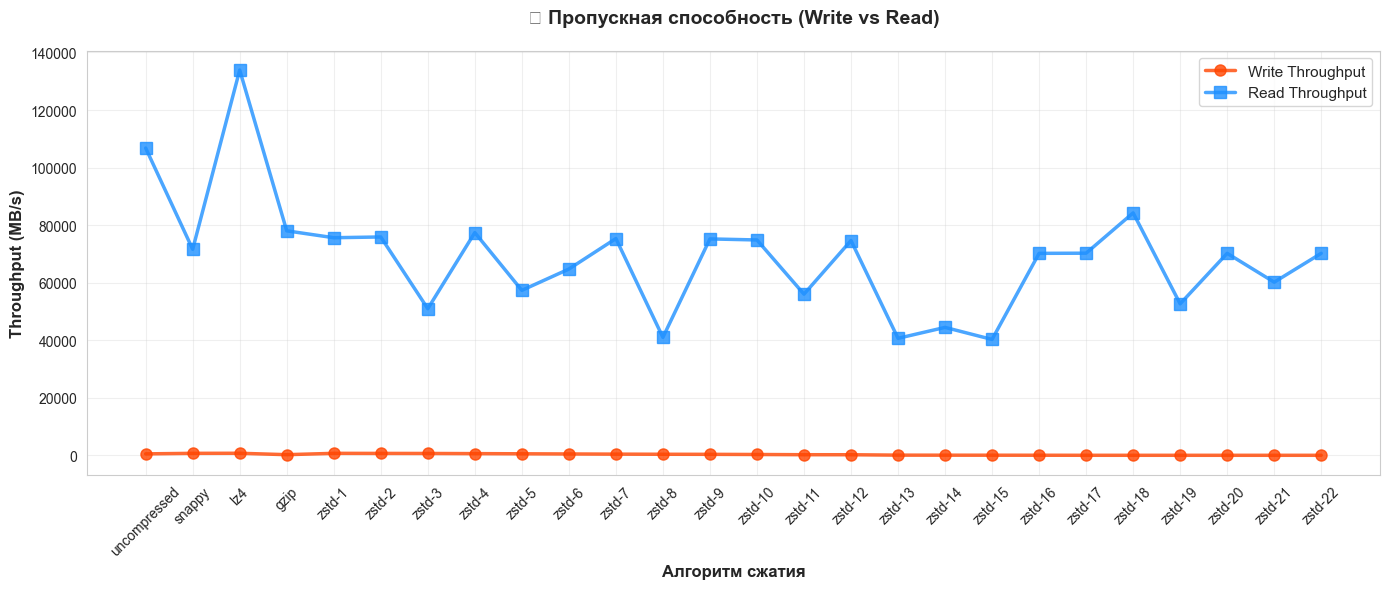

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


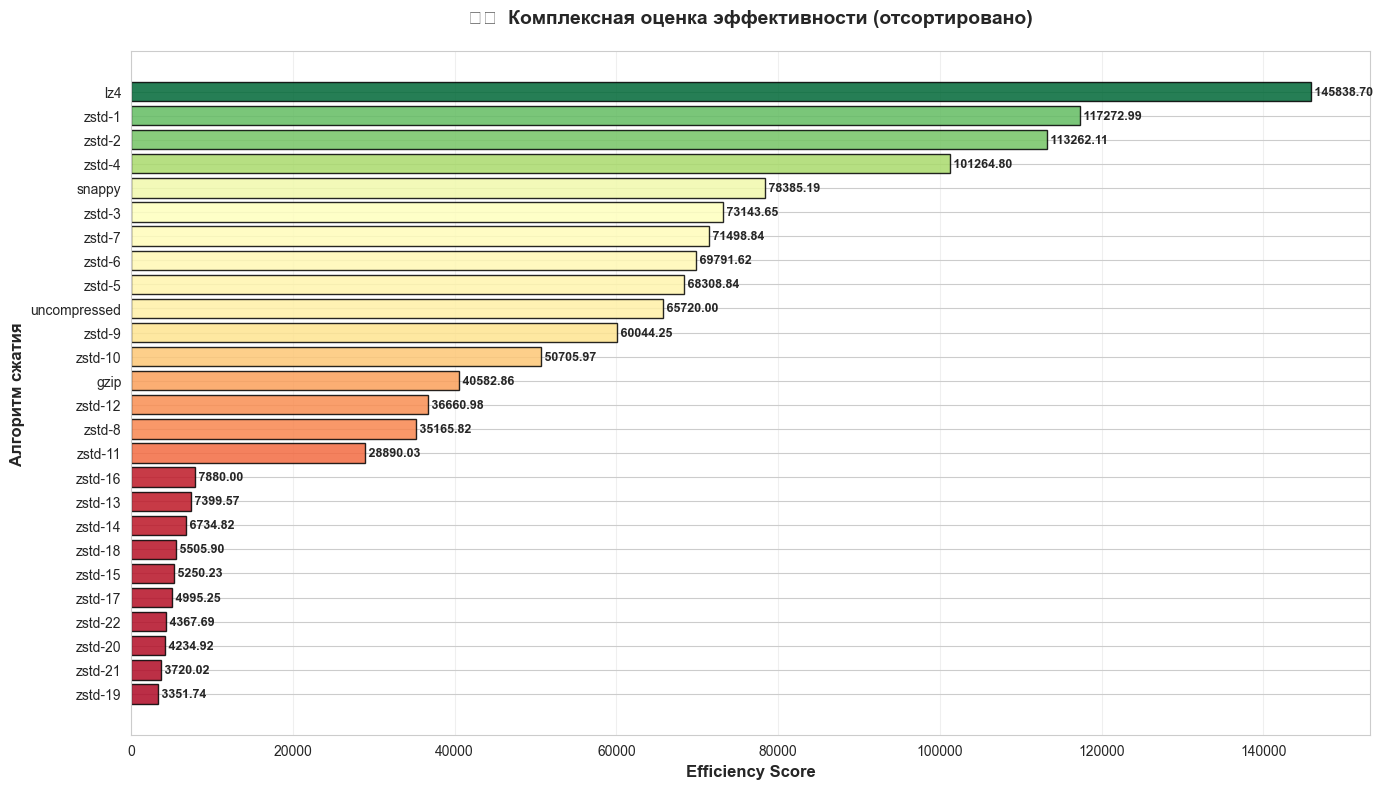


✅ Все графики построены!


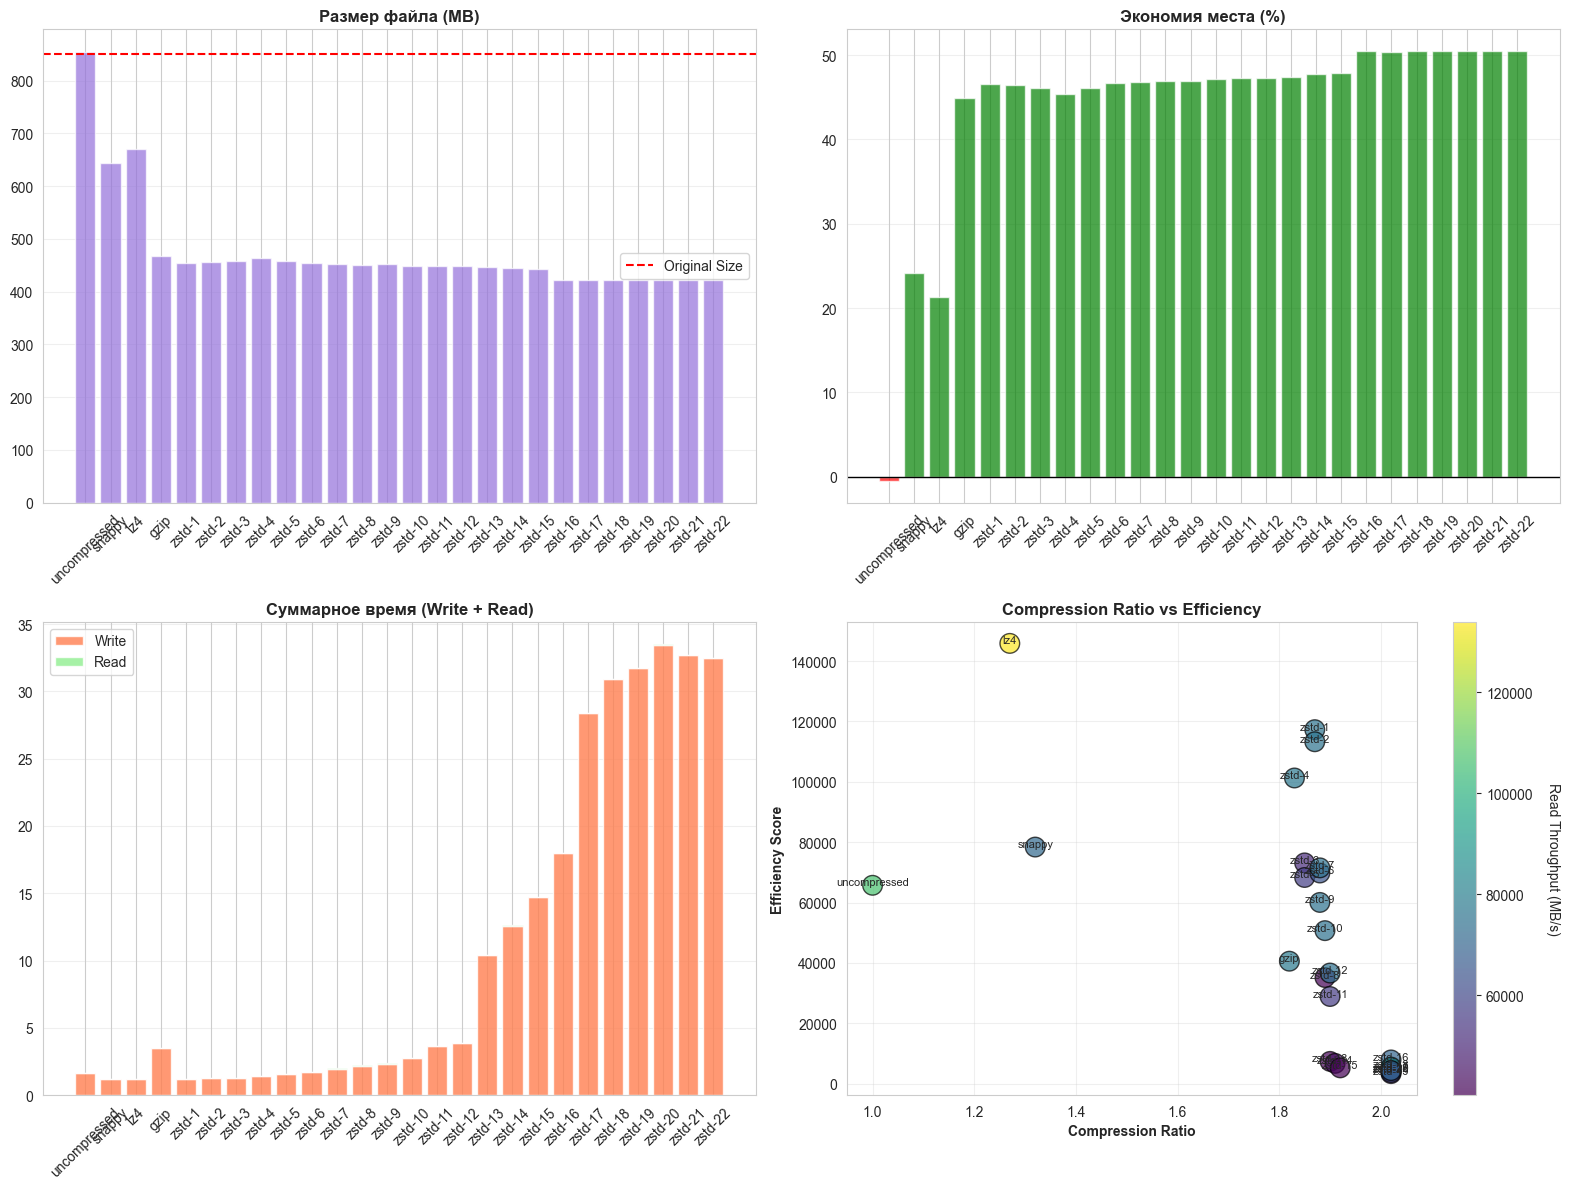


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [8]:
results_df = benchmark_compression_methods(
    source_file='data_10_000_000.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

display(results_df)

analyze_results(results_df)

plot_compression_analysis(results_df)

plot_comparison_summary(results_df)

save_results(results_df, 'compression_benchmark.csv')


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data_100_000_000.parquet
📏 Размер: 8499.93 MB
📈 Записей: 100,000,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 8542.6 MB (ratio: 1.0x, --0.5%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 6444.93 MB (ratio: 1.32x, -24.2%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 6694.35 MB (ratio: 1.27x, -21.2%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4681.03 MB (ratio: 1.82x, -44.9%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4537.46 MB (ratio: 1.87x, -46.6%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4553.22 MB (ratio: 1.87x, -46.4%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   ✅ Готово: 4586.47 MB (ratio: 1.85x, -46.0%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...
   📖 Чтение...
   

,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,19.743,0.1,0.1,0.01,0.031,0.005,0.83,2.4,0.0,...,430.53,275567.74,13935.86,100000000,1,benchmark_results/uncompressed/data.parquet,26.0,1.0,9.0,8.0
1,snappy,17.900,0.1,0.1,0.00,0.037,0.006,0.87,2.5,0.0,...,474.86,174187.30,12818.60,100000000,1,benchmark_results/snappy/data.parquet,24.0,3.0,6.0,9.0
2,lz4,18.298,0.3,0.3,0.00,0.031,0.009,0.53,1.5,0.0,...,464.53,215946.77,14962.76,100000000,1,benchmark_results/lz4/data.parquet,25.0,2.0,7.0,6.0
3,gzip,46.072,0.3,0.3,0.00,0.036,0.010,2.00,5.9,0.0,...,184.49,130028.61,5132.56,100000000,1,benchmark_results/gzip/data.parquet,23.0,22.0,16.0,16.0
4,zstd-1,12.096,0.0,0.0,0.00,0.034,0.004,0.70,1.8,0.0,...,702.71,133454.71,20573.81,100000000,1,benchmark_results/zstd_lvl1/data.parquet,18.5,19.0,2.0,3.0
5,zstd-2,12.033,0.3,0.3,0.00,0.031,0.007,0.73,1.9,0.0,...,706.38,146878.06,22767.07,100000000,1,benchmark_results/zstd_lvl2/data.parquet,18.5,10.0,1.0,1.0
6,zstd-3,14.340,0.3,0.3,0.00,0.028,0.007,0.80,2.1,0.0,...,592.74,163802.50,21090.94,100000000,1,benchmark_results/zstd_lvl3/data.parquet,20.5,4.0,3.0,2.0
7,zstd-4,14.441,0.0,0.0,0.00,0.033,0.008,0.87,2.0,0.0,...,588.60,140750.30,17795.57,100000000,1,benchmark_results/zstd_lvl4/data.parquet,22.0,14.0,4.0,4.0
8,zstd-5,17.011,0.3,0.3,0.00,0.029,0.000,1.03,2.8,0.0,...,499.67,158179.31,17173.22,100000000,1,benchmark_results/zstd_lvl5/data.parquet,20.5,5.0,5.0,5.0
9,zstd-6,19.329,0.3,0.3,0.00,0.030,0.016,1.37,3.8,0.0,...,439.75,151058.00,14669.61,100000000,1,benchmark_results/zstd_lvl6/data.parquet,15.5,7.0,8.0,7.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: zstd-16
   Compression Ratio: 2.02x
   Размер: 4211.48 MB
   Экономия: 50.5%

⚡ Самая быстрая запись: zstd-2
   Throughput: 706.38 MB/s
   Время: 12.033 s

🚀 Самое быстрое чтение: uncompressed
   Throughput: 275567.74 MB/s
   Время: 0.031 s

⚖️  Лучший баланс (Efficiency Score): zstd-2
   Score: 22767.07
   Compression Ratio: 1.87x
   Read Throughput: 146878.06 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): uncompressed
   • Warm Storage (баланс): zstd-2
   • Cold Storage (размер важнее): zstd-16



/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


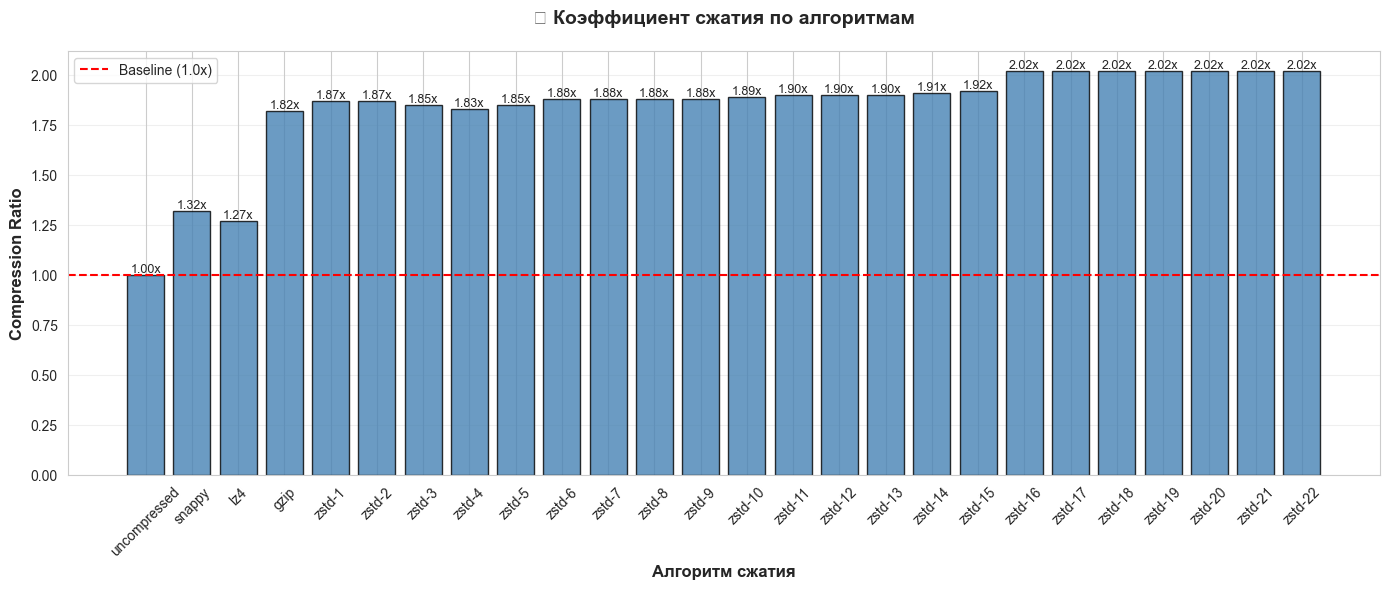

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9997 (\N{WRITING HAND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


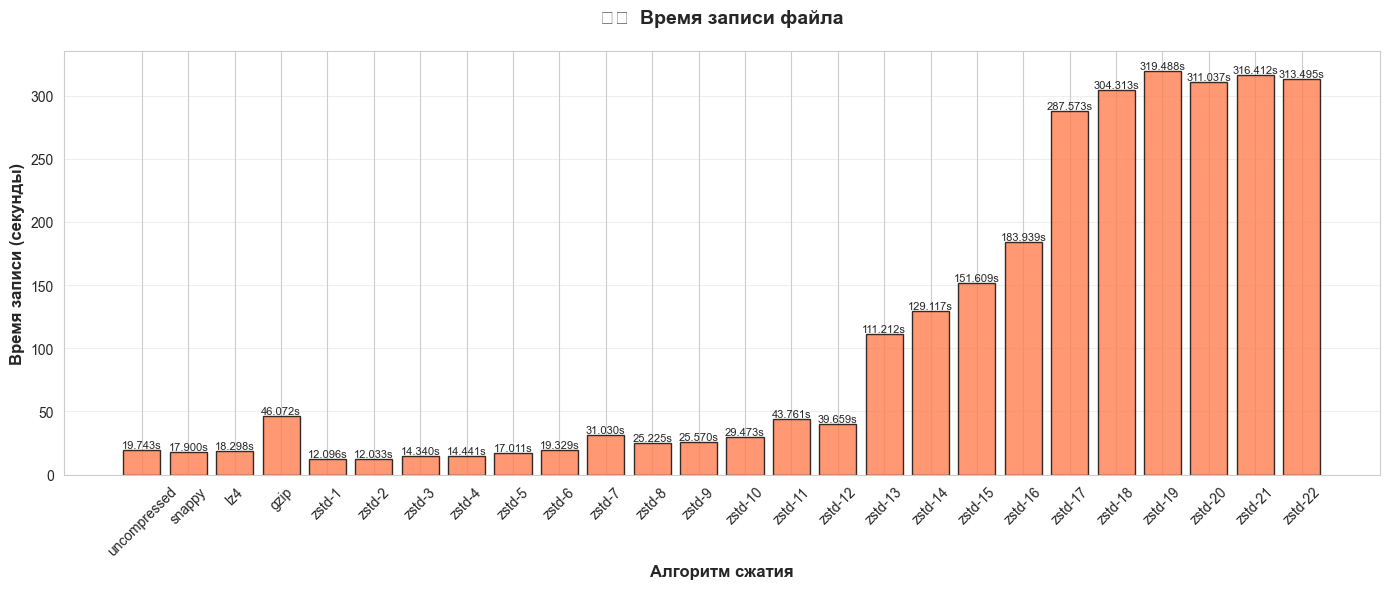

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


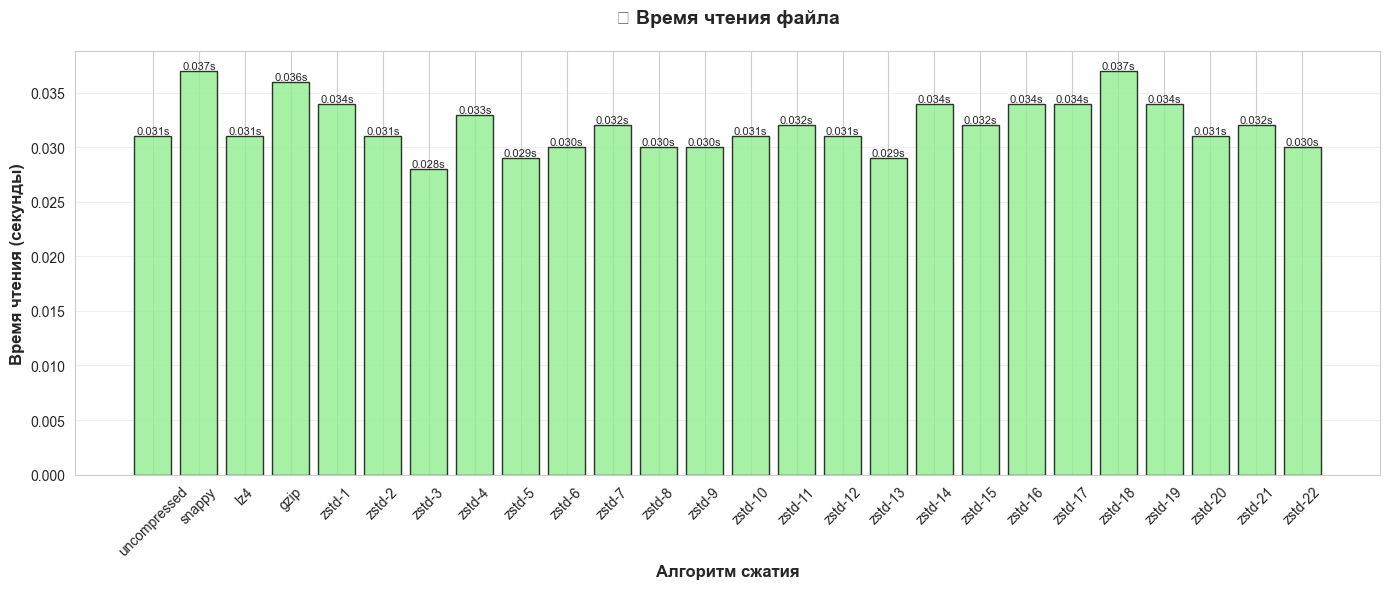

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


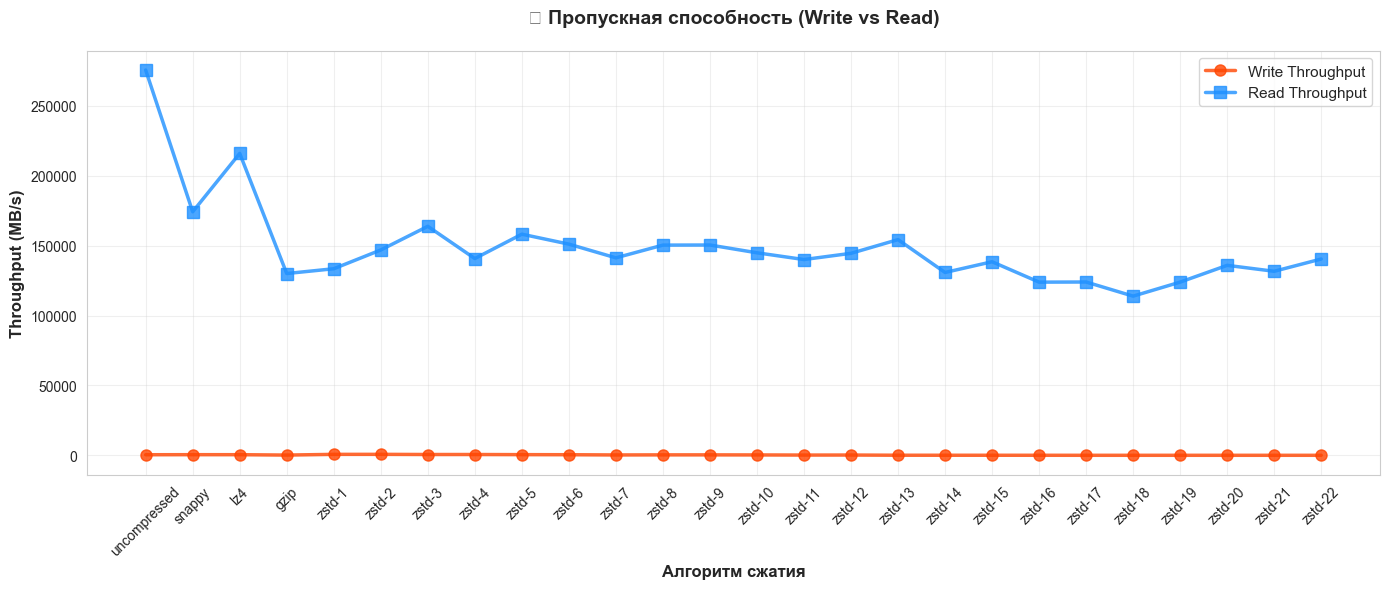

/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5v/5dcthwgx5dnfpx4n0b667hw00000gn/T/ipykernel_1130/3191925263.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/i.korsakov/_code/github/pet_project_compression_data/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


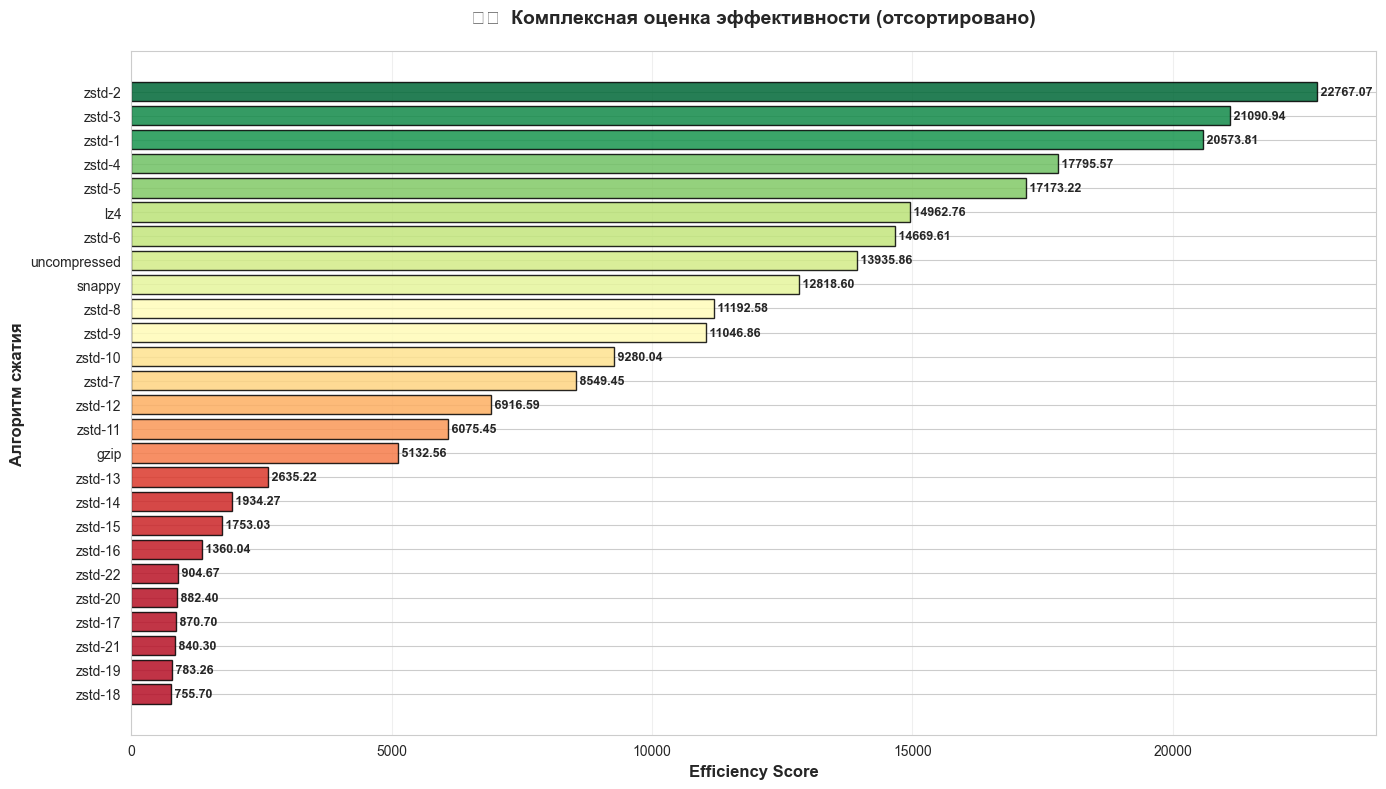


✅ Все графики построены!


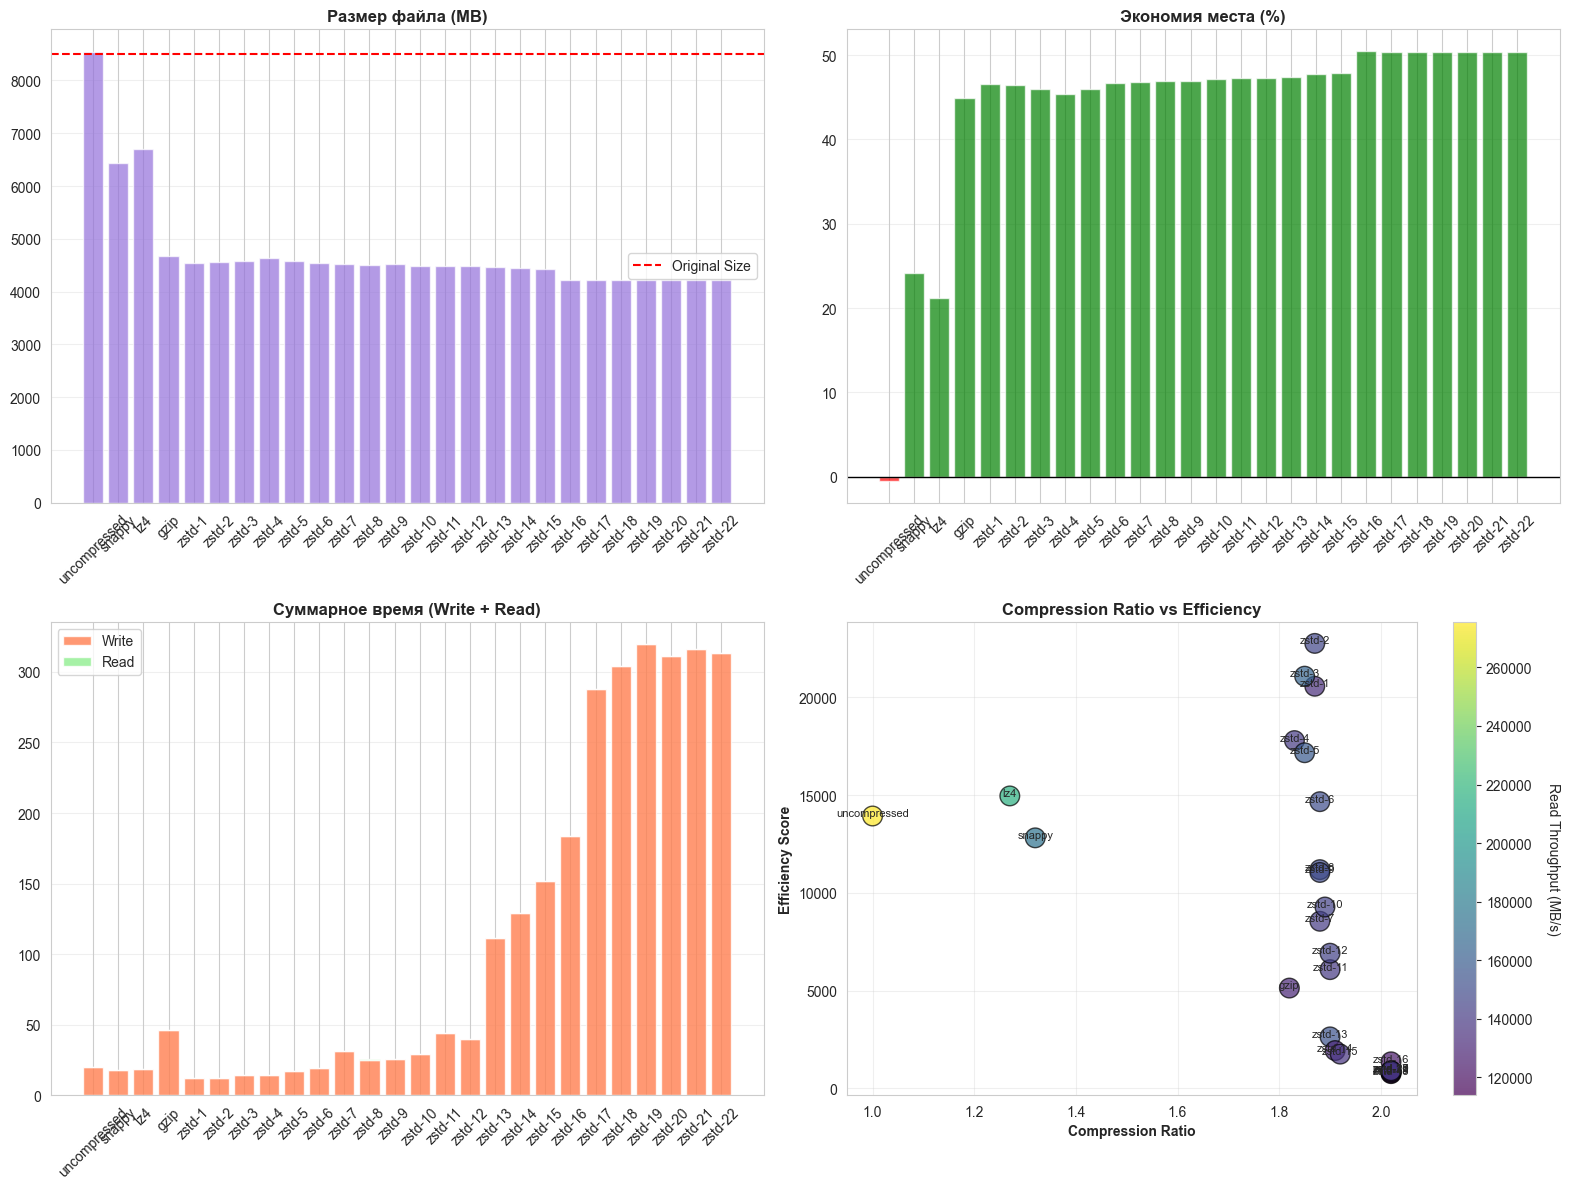


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [9]:
results_df = benchmark_compression_methods(
    source_file='data_100_000_000.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

display(results_df)

analyze_results(results_df)

plot_compression_analysis(results_df)

plot_comparison_summary(results_df)

save_results(results_df, 'compression_benchmark.csv')